Main Leaderboard

Forecaster  | Peer score against Pros | % Beat Pros on same Qs (Bootstrap) | % Beat Pros on same Qs (Resample)

Resample: Linear interpolation of two forecasters to determine "ground truth" for resampling. "Ground truth" = weighted combination of percent forecasts on each question that yields the most accurate score. Weights are 0 to 1.

Correlation: Deal with by assigning weights to questions. Weights for independent questions are 1. "Approximately correct rather than precisely wrong." Would be good to have a rule of thumb. These weights can be used for leaderboard above.

Likely want % beat Pros to be beyond 95% for significance - but obviously a sliding scale.

Can use this method for Metaculus Track Record! Have separate line for each platform - so can see significance against each platform. Then combine all competeing platforms and treat as the same forecaster going head-to-head against Metaculus!

Heroku:

Bots: https://data.heroku.com/dataclips/bmlboxtaewpwemfvqwktqxernfeq

Pros: https://data.heroku.com/dataclips/rozqhydlvqrzsllgmioruallozjx

In [1]:
# @title Import libraries
from functions import *
from IPython.display import display, clear_output
import pandas as pd

In [2]:
def display_head_and_tail(df: pd.DataFrame):
  display(df.head())
  display(df.tail())

In [3]:
# @title Create df_bot_resolved_questions, df_pro_resolved_questions, df_pro_bot_resolved_questions, df_bot_question_weights

"""
Input question data for both bots and pros.

Only look at questions that have resolved Yes or No.

df_pro_resolved_questions: Has pro_question_id, title, resolution, scheduled_close_time
df_bot_resolved_questions: Has bot_question_id, title, resolution, scheduled_close_time

All pro questions are asked to bots, but not all bot questions are asked to pros (correction:
not true in 2024 Q4, there were some that got launched to pros first? and were bad so they
didn't get asked of bots?)

To compare pros to bots, we need to match the pro_question_id with the bot_question_id.
This is done by matching the title and scheduled_close_time.

We remove early closers from the analysis. I do this by comparing actual close time to scheduled
close time in a later cell!

df_pro_bot_resolved_questions: Has pro_question_id, bot_question_id, title, resolution, scheduled_close_time, question_weight
"""

df_bot_scores = pd.read_csv(f'https://data.heroku.com/dataclips/nqghgczhvwahbmupzypyzaanabzv.csv')
df_bot_forecasts = pd.read_csv('https://data.heroku.com/dataclips/tfwiopapwgyjkawcpjmpibjlsars.csv')
df_bot_questions = df_bot_forecasts.rename(columns={'question_id': 'bot_question_id', 'question_title': 'title'})

df_pro_scores = pd.read_csv(f'https://data.heroku.com/dataclips/pcyecxbmoxppkxxaebikcwukhpqk.csv')
df_pro_forecasts = pd.read_csv('https://data.heroku.com/dataclips/roxytxphqvznkgbygmfgzymjtfxx.csv')
df_pro_questions = df_pro_forecasts.rename(columns={'question_id': 'pro_question_id', 'question_title': 'title'})

if False: # Temporary
    df_bot_questions = df_bot_questions[df_bot_questions['resolution'].isin(['yes', 'no'])]
    df_bot_forecasts = df_bot_forecasts[df_bot_forecasts['resolution'].isin(['yes', 'no'])]
    df_bot_scores = df_bot_scores[df_bot_scores['resolution'].isin(['yes', 'no'])]
    df_pro_questions = df_pro_questions[df_pro_questions['resolution'].isin(['yes', 'no'])]
    df_pro_forecasts = df_pro_forecasts[df_pro_forecasts['resolution'].isin(['yes', 'no'])]
    df_pro_scores = df_pro_scores[df_pro_scores['resolution'].isin(['yes', 'no'])]

df_pro_resolved_questions = df_pro_questions[['pro_question_id', 'title', 'resolution', 'scheduled_close_time', 'actual_close_time', 'question_weight', 'type', 'options', 'range_min', 'range_max']]
df_bot_resolved_questions = df_bot_questions[['bot_question_id', 'title', 'resolution', 'scheduled_close_time', 'actual_close_time', 'question_weight', 'type', 'options', 'range_min', 'range_max']]

df_pro_bot_resolved_questions = pd.merge(
    df_bot_resolved_questions,
    df_pro_resolved_questions[['pro_question_id', 'title', 'scheduled_close_time', 'question_weight']],
    on=['title', 'scheduled_close_time'],
    how='left'
)

df_pro_bot_resolved_questions['question_weight'] = df_pro_bot_resolved_questions['question_weight_x'].combine_first(df_pro_bot_resolved_questions['question_weight_y'])
df_pro_bot_resolved_questions.drop(['question_weight_x', 'question_weight_y'], axis=1, inplace=True)

# Remove duplicates
df_pro_bot_resolved_questions = df_pro_bot_resolved_questions.drop_duplicates()

# Cast both question ids to int64
df_pro_bot_resolved_questions['pro_question_id'] = df_pro_bot_resolved_questions['pro_question_id'].astype('Int64')
df_pro_bot_resolved_questions['bot_question_id'] = df_pro_bot_resolved_questions['bot_question_id'].astype('Int64')

# Remove df_bot_resolved_questions and df_pro_resolved_questions to make sure you only ever use df_pro_bot_resolved_questions
del df_bot_resolved_questions
del df_pro_resolved_questions

In [4]:
# Are any of the weights NOT 1 -- for Q3 we need to assign weights "manually" but for Q4 they are there
print(df_pro_bot_resolved_questions[df_pro_bot_resolved_questions['question_weight'] != 1].shape[0])

109


In [5]:
b = df_pro_bot_resolved_questions.shape

# How many are NA for pro_question_id?
a = df_pro_bot_resolved_questions['pro_question_id'].isna().sum()

print(f'Total number bot questions: {b[0]}')
print(f'Bot questions that don\'t have pro counterpart: {a}')
print(f'Overlap between bot and pro questions: {b[0]-a}')

Total number bot questions: 424
Bot questions that don't have pro counterpart: 325
Overlap between bot and pro questions: 99


In [6]:
# Weighted vs unweighted breakdown for those overlapping questions?
df_pro_bot_overlap = df_pro_bot_resolved_questions[~df_pro_bot_resolved_questions['pro_question_id'].isna()]
print(f'Unweighted count: {df_pro_bot_overlap.shape[0]}')
print(f'Weighted count: {df_pro_bot_overlap["question_weight"].sum()}')

Unweighted count: 99
Weighted count: 95.0


In [7]:
# @title Relationships between Bot Questions, create df_bot_question_related_weights (FOR Q3 ONLY)
if 25871 in df_pro_bot_resolved_questions['bot_question_id'].values:
  """
  Relationships between questions are entered as tuples. These relationships
  will be used to perform logical consistency checks.

  Weights are assigned to questions based on relationships. This is a way to
  deal with correlations between questions.
  """

  # Scope sensitity list of tuples where the first entry should equal the sum of the others
  bot_scope_questions = [
        (26019, 26017, 26018), # Starship launches
        (26098, 26096, 26097), # SENSEX
        (26159, 26158, 26157), # Geomagnetic storm July 28
        (26194, 26195, 26196), # measles cases
        (26006, 26005, 26004), # Trump lead over Biden
        (26642, 26643, 26644), # spanish wikipedia
        (26700, 26701, 26702), # market cap cryptocurrencies
        (27261, 27262, 27263), # Geomagnetic storm Sept 11
        ]

  # Sum of each tuple should logically equal 1
  bot_sum_to_1_questions = [
      (25952, 25953, 25954), # French PM party July 30
      (25957, 25958, 25959), # Tour de France winner
      (26570, 26571, 26572, 26573), # Warhammer
      (26574, 26575, 26576, 26577), # H5 cases in US
      (26671, 26670, 26669), # DOES NOT SUM TO EXACTLY 1 PM France Aug 31
      (27748, 27747, 27746, 27749), # Speed Chess
      (27488, 27489, 27490, 27491, 27492, 27493), # August CPI
      (27932, 27933, 27934, 27935), # Chinese youth unemployment
      (27484, 27485, 27486, 27487), # Fed rate cut Sept meeting
      (28045, 28044, 28043, 28042), # Afd vote share
      (28038, 28039, 28040, 28041), # Major Atlantic hurricanes
      (26776, 26777, 26778, 26779), # Seattle-Tacoma-Bellevu Air Quality
      ]

  # parent, child, if_yes, if_no
  bot_conditional_pair = [
      (26917, 26918, 26919, 26920) # israel lebanon conflict
  ]

  # CDFs - Logically the probability of each successive question must not decrease
  bot_increasing_questions = [
      (26981, 26982, 26983, 26984, 26985, 26986), # aircraft ADIZ
      (26977, 26978, 26979, 26980), # hurricane energy
      (27548, 27547, 27546, 27545), # mpox CDC risk level
      (28306, 28305, 28304, 28303, 28302), # Gas prices in US Sept 30
  ]

  bot_repeated_questions = [
      (26646, 26021), # mens 100m dash record
      (26555, 27021), # USA gold silver
      (26210, 26917), # israel invade lebanon
      (26781, 26304), # ruto
      (26100, 27136), # rfk drop out
      (25956, 27158), # democrat brokered convention
      (26102, 27022), # astronauts NOT EXACT REPEAT
      (26022, 27085), # arrest warrants NOT EXACT REPEAT
      (26235, 27281), # Buffett Indicator
      (26390, 27789), # Bubble Magnificent 7
      (26024, 27161), # QB Bo Nix starting for Broncos
      (26302, 27282), # riots
      (25955, 27157), # armed forces death US, China, Japan
      (26958, 27640), # Youtube banned in Russia
      (25936, 27141), # Crimean bridge attack
  ]

  bot_similar_questions = [
      (26915, 26916), # harris favorability
      (26913, 26914), # trump favorability
      (26193, 27733), # debate on Sept 10
      (27886, 27968), # Taylor Swift awards
      (27723, 27637), # Best Rock VMAs
      (27583, 27582, 27584, 27602, 27603, 27604), # mpox Zambia, US, Angola, Russia, Japan, Mexico
      (26306, 26838), # Richest people 250th > $10.2, 500th > 6.2
      (27887, 27969), # Emmys Outstanding Limited or Anthology Series
      (28206, 28207, 28208, 28209, 28210), # LMSYS leaderboard
      (28154, 28336), # Nigeria Edo gubernatorial election
      (26407, 27897), # Second Russian mobilization wave
      (27539, 26215), # Nuclear weapons used
      (27606, 27607, 27608, 27609, 27610), # Ukranian forces capture
      (26387, 27788), # Will Tesla increase deliveries in Q3 2024
      (26821, 26959), # VP debate
      (26212, 26213, 26214), # number of dairy cow herds with H5N1
      (26639, 26640, 26641) # Presidential debate 0, 1, or 2+
  ]

  ####### CREATE QUESTION WEIGHTS #########

  # Combine both lists of tuples
  all_questions = bot_scope_questions + bot_sum_to_1_questions + bot_increasing_questions + bot_similar_questions + bot_conditional_pair

  # Create an empty list to store the data
  data = []

  # Process each tuple
  for tuple_questions in all_questions:
      # Calculate the weight for each question in the tuple
      weight = np.log2(1 + len(tuple_questions))/(1 + len(tuple_questions))

      # Add each question and its weight to the data list
      for question_id in tuple_questions:
          data.append({'bot_question_id': question_id, 'question_weight': weight})

  # Process each tuple
  for tuple_questions in bot_repeated_questions:
      # 1st iteration has weight 1, 2nd has weight 1/2, 3rd weight 1/3....
      count = 1

      # Add each question and its weight to the data list
      for question_id in tuple_questions:
          data.append({'bot_question_id': question_id, 'question_weight': 1/count})
          count += 1

  # Create the DataFrame
  df = pd.DataFrame(data)

  # Sort the DataFrame by bot_question_id for better readability
  df_bot_question_related_weights = df.sort_values('bot_question_id').reset_index(drop=True)

# if df_bot_question_related_weights is defined, replace the question weights in df_pro_bot_resolved_questions
if 'df_bot_question_related_weights' in locals():
    df_pro_bot_resolved_questions = pd.merge(
        df_pro_bot_resolved_questions,
        df_bot_question_related_weights,
        on='bot_question_id',
        how='left'
    )

    df_pro_bot_resolved_questions['question_weight'] = df_pro_bot_resolved_questions['question_weight_y'].combine_first(df_pro_bot_resolved_questions['question_weight_x'])
    df_pro_bot_resolved_questions.drop(['question_weight_x', 'question_weight_y'], axis=1, inplace=True)

In [8]:
# Test: Are there any non-1 weights (there should be)
print(df_pro_bot_resolved_questions[df_pro_bot_resolved_questions['question_weight'] != 1].shape[0])

109


In [9]:
df_pro_bot_resolved_questions.columns

Index(['bot_question_id', 'title', 'resolution', 'scheduled_close_time',
       'actual_close_time', 'type', 'options', 'range_min', 'range_max',
       'pro_question_id', 'question_weight'],
      dtype='object')

In [10]:
# Unique pro questions, bot questions
pro_questions = df_pro_bot_resolved_questions['pro_question_id'].unique()
bot_questions = df_pro_bot_resolved_questions['bot_question_id'].unique()
print(pro_questions, bot_questions)

<IntegerArray>
[31268, 31269, 31270, 31280, 31281, 31282, 31292, 31293, 31294, 31322,  <NA>,
 31337, 31338, 31368, 31321, 33874, 33875, 33876, 33877, 33878, 33879, 33880,
 33881, 33882, 33883, 33884, 33885, 33886, 33887, 34245, 34246, 34247, 34248,
 34249, 34250, 34252, 34251, 34253, 34254, 34255, 34256, 34257, 34258, 34259,
 34487, 34488, 34489, 34490, 34491, 34493, 34494, 34495, 34496, 34497, 34498,
 34499, 34500, 34501, 34721, 34722, 34723, 34724, 34725, 34726, 34727, 34728,
 34729, 34730, 34733, 34734, 34961, 34959, 34960, 34962, 34963, 34964, 34965,
 34966, 34967, 34968, 34971, 34972, 35169, 35170, 35171, 35172, 35173, 35174,
 35175, 35176, 35177, 35178, 35377, 35378, 35379, 35380, 35381, 35385, 35386,
 35387]
Length: 100, dtype: Int64 <IntegerArray>
[31262, 31263, 31264, 31274, 31275, 31276, 31286, 31287, 31288, 31317,
 ...
 35614, 35615, 35616, 35617, 35618, 35619, 35620, 35621, 35622, 35705]
Length: 424, dtype: Int64


In [11]:
df_pro_bot_resolved_questions.dtypes

bot_question_id           Int64
title                    object
resolution               object
scheduled_close_time     object
actual_close_time        object
type                     object
options                  object
range_min               float64
range_max               float64
pro_question_id           Int64
question_weight         float64
dtype: object

In [12]:
# Remove early closers IF right now is before scheduled close time
df_pro_bot_resolved_questions['scheduled_close_time'] = pd.to_datetime(df_pro_bot_resolved_questions['scheduled_close_time']).dt.tz_localize(None)
df_pro_bot_resolved_questions['actual_close_time'] = pd.to_datetime(df_pro_bot_resolved_questions['actual_close_time']).dt.tz_localize(None)

In [13]:
remove_early_closers = False # SET TO FALSE WHEN ALL Q'S ARE RESOLVED
if remove_early_closers:
  df_pro_bot_resolved_questions = df_pro_bot_resolved_questions[(df_pro_bot_resolved_questions['actual_close_time'] <= df_pro_bot_resolved_questions['scheduled_close_time'])]

print('Number of unique questions in df_pro_bot_resolved_questions:', len(df_pro_bot_resolved_questions['bot_question_id']))

Number of unique questions in df_pro_bot_resolved_questions: 424


In [14]:
# Step 1: Read in the scores dataclips from heroku, take last (spot) score for each question_id, forecaster pair; make it into what Tom's code expects

## BOTS

# BASELINE
df_bot_baseline = df_bot_scores[df_bot_scores['score_type'] == 'spot_baseline']

# Take the LAST score for each (forecaster, question_id) pair
df_bot_baseline = df_bot_baseline.groupby(['question_id', 'forecaster']).last().reset_index()

# PEER
df_bot_peer = df_bot_scores[df_bot_scores['score_type'] == 'spot_peer']

# Take the LAST score for each (forecaster, question_id) pair
df_bot_peer = df_bot_peer.groupby(['question_id', 'forecaster']).last().reset_index()

## PROS

# BASELINE
df_pro_baseline = df_pro_scores[df_pro_scores['score_type'] == 'spot_baseline']

# Take the LAST score for each (forecaster, question_id) pair
df_pro_baseline = df_pro_baseline.groupby(['question_id', 'forecaster']).last().reset_index()
df_pro_baseline_long = df_pro_baseline.copy()

In [15]:
# Process forecasts (consolidate forecast columns; take the last forecast from each forecaster for each question)
df_bot_forecasts = process_forecasts(df_bot_forecasts)
df_pro_forecasts = process_forecasts(df_pro_forecasts)

# Add median rows
df_bot_forecasts = add_median_rows(add_is_median(df_bot_forecasts), 'bot')
df_pro_forecasts = add_median_rows(add_is_median(df_pro_forecasts), 'pro')

In [16]:
df_pro_forecasts.head()

,question_id,forecaster,question_title,created_at,author_id,resolution,scheduled_close_time,actual_close_time,question_weight,type,options,range_min,range_max,post_id,forecast,is_median
0,31268,Jgalt,"For Q1 2025, how many banks will be listed on ...",2025-01-17 19:06:22.013528+00,101465,1,2025-01-20 03:27:00+00,2025-01-20 03:27:00+00,1.0,multiple_choice,"[""0"",""1"",""2-3"",""4-6"","">6""]",NaN,NaN,31736,"[0.001,0.568,0.366,0.041,0.024]",False
1,31268,MaciekK,"For Q1 2025, how many banks will be listed on ...",2025-01-17 19:06:22.013528+00,117580,1,2025-01-20 03:27:00+00,2025-01-20 03:27:00+00,1.0,multiple_choice,"[""0"",""1"",""2-3"",""4-6"","">6""]",NaN,NaN,31736,"[0.001,0.62,0.35,0.019,0.01]",True
2,31268,OpenSystem,"For Q1 2025, how many banks will be listed on ...",2025-01-17 19:06:22.013528+00,120160,1,2025-01-20 03:27:00+00,2025-01-20 03:27:00+00,1.0,multiple_choice,"[""0"",""1"",""2-3"",""4-6"","">6""]",NaN,NaN,31736,"[0.005,0.7,0.25,0.04,0.005]",False
5,31268,darkives,"For Q1 2025, how many banks will be listed on ...",2025-01-17 19:06:22.013528+00,103907,1,2025-01-20 03:27:00+00,2025-01-20 03:27:00+00,1.0,multiple_choice,"[""0"",""1"",""2-3"",""4-6"","">6""]",NaN,NaN,31736,"[0.001,0.49,0.365,0.1,0.044]",False
6,31268,datscilly,"For Q1 2025, how many banks will be listed on ...",2025-01-17 19:06:22.013528+00,103777,1,2025-01-20 03:27:00+00,2025-01-20 03:27:00+00,1.0,multiple_choice,"[""0"",""1"",""2-3"",""4-6"","">6""]",NaN,NaN,31736,"[0.001,0.56,0.36,0.059,0.02]",False


In [17]:
# ADD THE BOT MEDIAN SPOT SCORES & REMOVE UNNECESSARY COLUMNS
df_bot_baseline = df_bot_baseline[['question_id', 'question_title', 'question_weight', 'forecaster', 'score', 'resolution']]

# Add bot_median rows
df_bot_baseline = df_bot_baseline.merge(df_bot_forecasts[['question_id', 'forecaster', 'is_median']], on=['question_id', 'forecaster'], how='left')
df_bot_baseline = add_median_rows(df_bot_baseline, 'bot')

df_bot_baseline_long = df_bot_baseline.copy()

# DO THE SAME FOR DF_BOT_PEER
df_bot_peer = df_bot_peer[['question_id', 'question_title', 'question_weight', 'forecaster', 'score', 'resolution']]

# Add bot_median rows
df_bot_peer = df_bot_peer.merge(df_bot_forecasts[['question_id', 'forecaster', 'is_median']], on=['question_id', 'forecaster'], how='left')
df_bot_peer = add_median_rows(df_bot_peer, 'bot')

In [18]:
all_bots = df_bot_peer['forecaster'].unique()
all_bots

array(['metac-Llama-3.1', 'metac-Gemini-Exp-1206', 'acm_bot',
       'NextWorldLab', 'metac-o1-preview', 'metac-perplexity', 'mmBot',
       'metac-claude-3-5-sonnet-latest', 'Grizeu_Bot', 'GreeneiBot2',
       'InstitutPelFutur', 'metac-claude-3-5-sonnet-20240620', 'metac-o1',
       'metac-grok-2-1212', 'metac-gpt-4o', 'bot_median', 'pgodzinai',
       'metac-exa', 'jkraybill_bot', 'VeritasAI', 'MWG', 'twsummerbot',
       'CatrachoCaster', 'X_bot', 'manticAI', 'annabot', 'minefrac1',
       'metac-deepseek-r1', 'Bot_Pepa', 'laylaps', 'ajf-bot',
       'SynapseSeer', 'RPM_bot', 'cookics_bot_TEST', 'ProfessorSP',
       'wunderplumb', 'CumulativeBot', 'pianobot', 'krm-bot',
       'KevinTestBot', '4Shadower', 'swingswish', 'jonahsingerbot',
       'bean_bot', 'andrewsiah', 'cobyj-bot'], dtype=object)

In [19]:
# Calculate and show results
ranked_forecasters = calculate_weighted_stats(df_bot_peer)

display_head_and_tail(ranked_forecasters)

,forecaster,weighted_mean,weighted_sum,n_questions,ci_lower,weighted_se
15,bot_median,9.993738,3777.832847,409,7.260052,1.390626
12,metac-o1,9.674740,3631.123492,406,6.257418,1.738353
4,metac-o1-preview,8.465638,3121.449998,399,3.947903,2.298000
24,manticAI,6.510835,2055.210309,337,0.552564,3.029040
1,metac-Gemini-Exp-1206,5.417367,1880.476418,377,0.876988,2.309106


,forecaster,weighted_mean,weighted_sum,n_questions,ci_lower,weighted_se
19,VeritasAI,-4.854808,-1602.183635,361,-8.860367,2.036820
26,minefrac1,-9.333648,-1757.059251,202,-15.440064,3.096816
8,Grizeu_Bot,-9.743831,-1882.605577,207,-17.494967,3.931500
14,metac-gpt-4o,-5.987786,-2235.360274,404,-10.422687,2.255950
30,ajf-bot,-14.000701,-3208.260547,244,-24.482548,5.321344


In [20]:
# @title Create df_bot_baseline, df_bot_peer, df_bot_forecasts, bots

"""
df_bot_baseline: Spot Baseline scores for all bots & bot_median

df_bot_peer: Spot Peer scores for all bots & bot_median. Can be used to recreate
the tournament leaderboard on the site.

df_bot_forecasts: Spot forecasts for all bots & bot_median, ie only counts the
final forecast

bots: a list of all bots
"""

# Pivot df_bot_baseline
df_bot_baseline = df_bot_baseline.rename(columns={'question_id': 'bot_question_id'})
#df_bot_baseline['score'] = pd.to_numeric(df_bot_baseline['score'], errors='coerce')
df_pivoted = df_bot_baseline.pivot(index='bot_question_id', columns='forecaster', values='score')
df_pivoted = df_pivoted.reset_index()
df_pivoted = df_pivoted.reindex(sorted(df_pivoted.columns), axis=1)

# Move 'question_id' to be the first column
cols = df_pivoted.columns.tolist()
cols = ['bot_question_id'] + [col for col in cols if col != 'bot_question_id']
df_pivoted = df_pivoted[cols]

all_columns = df_pivoted.columns.tolist()
# Remove 'question_id' and 'bot_median' from the list if they exist
all_columns = [col for col in all_columns if col not in ['bot_question_id', 'bot_median']]
new_column_order = ['bot_question_id', 'bot_median'] + all_columns
df_pivoted = df_pivoted[new_column_order]
df_bot_baseline_wide = df_pivoted
df_bot_baseline_wide['bot_question_id'] = pd.to_numeric(df_bot_baseline_wide['bot_question_id'], errors='coerce')

# Create df_bot_peer
df_bot_peer = df_bot_peer.rename(columns={'question_id': 'bot_question_id'})
df_bot_peer['score'] = pd.to_numeric(df_bot_peer['score'], errors='coerce')

df_bot_peer_wide = make_wide(df_bot_peer, df_pro_bot_resolved_questions)

In [21]:
print(df_bot_baseline_wide.shape)

array_fewer = np.array([28922, 28923, 28924, 28932, 28933, 28934, 28935, 28936, 28937, 28938, 28958, 28959, 28960, 28985, 28986, 28987, 28988, 28989, 28990, 28991, 28992, 28993, 28994, 28995, 29021, 29022, 29023, 29024, 29025, 29026, 29027, 29028, 29029, 29030, 29031, 29032, 29033, 29034, 29035, 29036, 29037, 29066, 29067, 29068, 29069, 29070, 29071, 29072, 29074, 29075, 29077, 29108, 29109, 29110, 29111, 29112, 29113, 29114, 29115, 29116, 29117, 29119, 29162, 29163, 29164, 29165, 29166, 29168, 29169, 29170, 29171, 29172, 29173, 29174, 29175, 29176, 29177, 29200, 29201, 29202, 29203, 29204, 29205, 29206, 29207, 29208, 29209, 29210, 29211, 29248, 29249, 29250, 29251, 29252, 29253, 29254, 29255, 29256, 29257, 29258, 29296, 29297, 29298, 29299, 29300, 29301, 29302, 29303, 29304, 29305, 29306, 29347, 29348, 29349, 29350, 29351, 29353, 29354, 29355, 29356, 29358, 29359, 29360, 29361, 29362, 29414, 29415, 29417, 29418, 29419, 29420, 29421, 29422, 29423, 29460, 29461, 29462, 29463, 29464, 29465, 29466, 29467, 29471, 29472, 29503, 29504, 29505, 29506, 29507, 29508, 29510, 29511, 29512, 29513, 29556, 29557, 29558, 29559, 29560, 29561, 29562, 29563, 29564, 29565, 29566, 29567, 29568, 29569, 29635, 29636, 29637, 29638, 29639, 29640, 29641, 29642, 29643, 29644, 29645, 29646, 29647, 29648, 29649, 29650, 29714, 29715, 29716, 29717, 29718, 29719, 29720, 29721, 29722, 29723, 29724, 29725, 29726, 29727, 29728, 29729, 29771, 29773, 29774, 29775, 29776, 29777, 29778, 29779, 29780, 29781, 29828, 29829, 29830, 29831, 29832, 29833, 29834, 29835, 29836, 29837, 29838, 29839, 29840, 29908, 29909, 29910, 29911, 29912, 29913, 29914, 29915, 29916, 29917, 29940, 29941, 29942, 29943, 29944, 29945, 29946, 29947, 29948, 29949, 29950, 29951, 29952, 29953, 29954, 29985, 29987, 29988, 29989, 29990, 29991, 29992, 29993, 29994, 29995, 29996, 29997, 29998, 30079, 30080, 30081, 30082, 30083, 30084, 30085, 30086, 30087, 30088, 30089, 30090, 30091, 30120, 30121, 30122, 30123, 30124, 30125, 30126, 30127, 30154, 30155, 30156, 30157, 30158, 30159, 30160, 30161, 30162, 30193, 30194, 30196, 30197, 30198, 30199, 30200, 30248, 30250, 30251, 30252, 30253, 30254, 30255, 30256, 30257, 30281, 30282, 30283, 30284, 30285, 30286, 30287, 30288, 30289, 30290, 30317, 30318, 30320, 30321, 30322, 30323, 30324, 30348, 30349, 30350, 30351, 30352, 30353, 30385, 30386, 30387, 30388, 30389, 30392, 30393, 30394, 30395, 30435, 30437, 30438, 30439, 30440, 30441, 30442, 30443, 30444, 30445, 30446, 30447, 30496, 30497, 30498, 30499, 30500, 30501, 30502, 30503, 30504, 30505, 30532, 30533, 30534, 30535, 30536, 30537, 30576, 30577, 30578, 30579, 30580, 30581, 30582, 30583, 30584, 30585, 30586, 30587, 30613, 30614, 30615, 30617, 30637, 30638, 30639, 30640, 30641, 30723, 30724, 30725, 30726, 30740, 30741, 30787, 30791, 30792, 30793, 30794, 30795, 30796, 30797])

# List all questions in df_bot_baseline_wide
array_new = df_bot_baseline_wide['bot_question_id'].unique()

# What's the difference? between questions pre-median fix and questions now (more now):
diff = set(array_new) - set(array_fewer)

diff

(409, 47)


{np.int64(31262),
 np.int64(31263),
 np.int64(31264),
 np.int64(31274),
 np.int64(31275),
 np.int64(31276),
 np.int64(31286),
 np.int64(31287),
 np.int64(31288),
 np.int64(31317),
 np.int64(31318),
 np.int64(31332),
 np.int64(31333),
 np.int64(31334),
 np.int64(31366),
 np.int64(31370),
 np.int64(33735),
 np.int64(33736),
 np.int64(33737),
 np.int64(33738),
 np.int64(33739),
 np.int64(33740),
 np.int64(33741),
 np.int64(33742),
 np.int64(33743),
 np.int64(33744),
 np.int64(33745),
 np.int64(33746),
 np.int64(33747),
 np.int64(33748),
 np.int64(33749),
 np.int64(33750),
 np.int64(33751),
 np.int64(33752),
 np.int64(33753),
 np.int64(33754),
 np.int64(33755),
 np.int64(33756),
 np.int64(33757),
 np.int64(33758),
 np.int64(33759),
 np.int64(33760),
 np.int64(33761),
 np.int64(33762),
 np.int64(33763),
 np.int64(33764),
 np.int64(33765),
 np.int64(33766),
 np.int64(33767),
 np.int64(33768),
 np.int64(33769),
 np.int64(33770),
 np.int64(33771),
 np.int64(33772),
 np.int64(33773),
 np.int64(

In [22]:
# @title Bot Baseline Leaderboard

# Calculate the total score for each bot
total_scores = df_bot_baseline_wide.iloc[:, 1:].fillna(0).sum()

# Create a new dataframe with the total scores
df_total_scores = pd.DataFrame({'Bot': total_scores.index, 'Baseline_Score': total_scores.values})

# Sort the dataframe by Total_Score in descending order
df_total_scores_sorted = df_total_scores.sort_values('Baseline_Score', ascending=False)

# Add a Rank column
df_total_scores_sorted['Rank'] = range(1, len(df_total_scores_sorted) + 1)

# Set Rank as the index
df_total_scores_ranked = df_total_scores_sorted.set_index('Rank')

# Display the result
display_head_and_tail(df_total_scores_ranked)

,Bot,Baseline_Score
Rank,,
1,bot_median,9389.288325
2,metac-o1,8861.959039
3,metac-o1-preview,8849.559824
4,acm_bot,7605.922314
5,manticAI,7061.660958


,Bot,Baseline_Score
Rank,,
42,Bot_Pepa,-510.750607
43,Grizeu_Bot,-714.098920
44,ajf-bot,-776.386700
45,minefrac1,-905.116263
46,RPM_bot,-911.357676


In [23]:
# Make sure df_bot_baseline_wide has ONE forecast per (forecaster, question_id) pair
# Check for duplicates
print(df_bot_baseline_wide.duplicated(subset=['bot_question_id', 'bot_median']).sum())

0


In [24]:
# @title Bot Peer Leaderboard

"""
NOTE: This can be different from the leaderboad on the site IF early closers
are excluded (check remove_early_closers bool).
"""

df_filled = df_bot_peer_wide.fillna(0)
#df_filled = df_filled.drop(['bot_question_id', 'question_weight'], axis=1)

# Calculate the total score for each player
total_scores = df_filled.sum()

# Create a new DataFrame for the leaderboard
leaderboard = pd.DataFrame({
    'bot': total_scores.index,
    'Peer Score': total_scores.values
})

# Remove bot_question_id from the leaderboard
leaderboard = leaderboard[leaderboard['bot'] != 'bot_question_id']

# Sort the leaderboard by Total Score in descending order
leaderboard = leaderboard.sort_values('Peer Score', ascending=False)

# Reset the index and add a 'Rank' column
leaderboard = leaderboard.reset_index(drop=True)
leaderboard.index += 1
leaderboard.index.name = 'Rank'

# Display the leaderboard
leaderboard

,bot,Peer Score
Rank,,
1,bot_median,4077.448023
2,metac-o1,3864.168122
3,metac-o1-preview,3162.155445
4,manticAI,2142.538438
5,metac-Gemini-Exp-1206,2072.216227
6,acm_bot,1876.466009
7,twsummerbot,1763.532046
8,metac-perplexity,1697.555196
9,GreeneiBot2,1603.998618


In [25]:
## ADD PRO_MEDIAN ROWS

# ADD THE PRO MEDIAN SPOT SCORES & REMOVE UNNECESSARY COLUMNS
df_pro_scores = df_pro_baseline
df_pro_baseline = df_pro_baseline[['question_id', 'question_title', 'question_weight', 'forecaster', 'score', 'resolution']]

# Add pro_median rows
df_pro_baseline = df_pro_baseline.merge(df_pro_forecasts[['question_id', 'forecaster', 'is_median']], on=['question_id', 'forecaster'], how='left')
df_pro_baseline = add_median_rows(df_pro_baseline, 'pro')

df_pro_baseline_long = df_pro_baseline.copy()

In [26]:
df_bot_scores = df_bot_scores[df_bot_scores['score_type'] == 'spot_baseline']

In [27]:
# Print WEIGHTED average for pro_median
print("PRO MEDIAN")
pro_median_baseline = df_pro_baseline_long[df_pro_baseline_long['forecaster'] == 'pro_median']
print(f'Average baseline: {(pro_median_baseline["score"] * pro_median_baseline["question_weight"]).sum() / pro_median_baseline["question_weight"].sum()}')

PRO MEDIAN
Average baseline: 44.964801909223056


In [28]:
df_pro_forecasts.head()

,question_id,forecaster,question_title,created_at,author_id,resolution,scheduled_close_time,actual_close_time,question_weight,type,options,range_min,range_max,post_id,forecast,is_median
0,31268,Jgalt,"For Q1 2025, how many banks will be listed on ...",2025-01-17 19:06:22.013528+00,101465,1,2025-01-20 03:27:00+00,2025-01-20 03:27:00+00,1.0,multiple_choice,"[""0"",""1"",""2-3"",""4-6"","">6""]",NaN,NaN,31736,"[0.001,0.568,0.366,0.041,0.024]",False
1,31268,MaciekK,"For Q1 2025, how many banks will be listed on ...",2025-01-17 19:06:22.013528+00,117580,1,2025-01-20 03:27:00+00,2025-01-20 03:27:00+00,1.0,multiple_choice,"[""0"",""1"",""2-3"",""4-6"","">6""]",NaN,NaN,31736,"[0.001,0.62,0.35,0.019,0.01]",True
2,31268,OpenSystem,"For Q1 2025, how many banks will be listed on ...",2025-01-17 19:06:22.013528+00,120160,1,2025-01-20 03:27:00+00,2025-01-20 03:27:00+00,1.0,multiple_choice,"[""0"",""1"",""2-3"",""4-6"","">6""]",NaN,NaN,31736,"[0.005,0.7,0.25,0.04,0.005]",False
5,31268,darkives,"For Q1 2025, how many banks will be listed on ...",2025-01-17 19:06:22.013528+00,103907,1,2025-01-20 03:27:00+00,2025-01-20 03:27:00+00,1.0,multiple_choice,"[""0"",""1"",""2-3"",""4-6"","">6""]",NaN,NaN,31736,"[0.001,0.49,0.365,0.1,0.044]",False
6,31268,datscilly,"For Q1 2025, how many banks will be listed on ...",2025-01-17 19:06:22.013528+00,103777,1,2025-01-20 03:27:00+00,2025-01-20 03:27:00+00,1.0,multiple_choice,"[""0"",""1"",""2-3"",""4-6"","">6""]",NaN,NaN,31736,"[0.001,0.56,0.36,0.059,0.02]",False


In [29]:
# @title Create df_pro_bot_forecasts, df_bot_vs_pro_peer, df_bot_vs_pro_leaderboard, df_bot_vs_pro_weighted_leaderboard

"""
df_pro_bot_forecasts: Spot forecasts for all bots & pro_median, question resolutions, and question weights

df_bot_vs_pro_peer: Calculates Peer scores as if there is a tournament with only
a single bot and the pro_median. This is the main comparison metric for
assessing how a bot compares to the human aggregate. Positive scores mean that
the bot did better than the pro_median. Negative scores mean that the bot did
worse than the pro_median.

df_bot_vs_pro_leaderboard: A leaderboard based on df_bot_vs_pro_peer.

df_bot_vs_pro_weighted_leaderboard: A leaderboard based on df_bot_vs_pro_peer
with question weighting.
"""

# Now pivot df_pro_forecasts; forecaster = columns; forecast = values; index = pro_question_id
df_pro_forecasts = df_pro_forecasts.rename(columns={'question_id': 'pro_question_id'})
df_pro_forecasts = df_pro_forecasts.pivot(index='pro_question_id', columns='forecaster', values='forecast')
# Make the index a column and make it numeric
df_pro_forecasts = df_pro_forecasts.reset_index()

# Now pivot df_bot_forecasts; forecaster = columns; forecast = values; index = pro_question_id
df_bot_forecasts = df_bot_forecasts.rename(columns={'question_id': 'bot_question_id'})
df_bot_forecasts = df_bot_forecasts.pivot(index='bot_question_id', columns='forecaster', values='forecast')
# Make the index a column and make it numeric
df_bot_forecasts = df_bot_forecasts.reset_index()

# One row per question, with pro_question_id and bot_question_id and resolution
df_pro_bot_resolved_questions_first = df_pro_bot_resolved_questions.groupby(['pro_question_id', 'bot_question_id']).first().reset_index()[['pro_question_id', 'bot_question_id', 'resolution', 'question_weight', 'type', 'options']]

df2 = pd.merge(
    df_pro_bot_resolved_questions_first,
    df_pro_forecasts[['pro_question_id', 'pro_median']],
    on='pro_question_id',
    how='left'
)

df_pro_bot_forecasts = pd.merge(
    df2,
    df_bot_forecasts,
    on='bot_question_id',
    how='left'
)

display_head_and_tail(df_pro_bot_forecasts)

,pro_question_id,bot_question_id,resolution,question_weight,type,options,pro_median,4Shadower,Bot_Pepa,CatrachoCaster,...,metac-o1,metac-o1-preview,metac-perplexity,minefrac1,mmBot,pgodzinai,pianobot,swingswish,twsummerbot,wunderplumb
0,31268,31262,0,1.0,multiple_choice,"[""0"",""1"",""2-3"",""4-6"","">6""]","[0.001,0.62,0.35,0.019,0.01]",NaN,NaN,NaN,...,"[0.45,0.3,0.15,0.05,0.05]","[0.02,0.7,0.2,0.07,0.01]","[0.35000000000000003,0.30000000000000004,0.250...",NaN,"[0.009900990099009901,0.39603960396039606,0.44...","[0.014925742574257425,0.5137871287128712,0.334...",NaN,NaN,NaN,NaN
1,31269,31263,86.82,1.0,numeric,None,"[0.0013749738,0.0014499743,0.001526641,0.00160...",NaN,NaN,NaN,...,"[0.05,0.0505555556,0.0511111111,0.0516666667,0...","[0.05,0.0506666667,0.0513333333,0.052,0.052666...","[0.05,0.0508333333,0.0516666667,0.0525,0.05333...",NaN,"[0.0215944348,0.0218024136,0.0220262706,0.0222...","[0.001,0.001060875,0.0011396,0.0012863125,0.00...",NaN,NaN,NaN,NaN
2,31270,31264,no,1.0,binary,None,0.013,NaN,NaN,NaN,...,0.1,0.05,0.1,NaN,0.2,0.07,NaN,NaN,NaN,NaN
3,31280,31274,5-9,1.0,multiple_choice,"[""0-4"",""5-9"","">9""]","[0.16,0.44,0.4]",NaN,NaN,"[0.16,0.47,0.37]",...,"[0.3,0.55,0.15]","[0.2,0.6,0.2]","[0.1,0.6,0.3]",NaN,"[0.25,0.5,0.25]","[0.27499999999999997,0.5125,0.21249999999999997]",NaN,NaN,"[0.116,0.42,0.464]",NaN
4,31281,31275,119.2,1.0,numeric,None,"[0.0,0.0005044914,0.0010323506,0.0015847475,0....",NaN,NaN,NaN,...,"[0.0,0.0028571429,0.0057142857,0.0085714286,0....","[0.0,0.004,0.008,0.012,0.016,0.02,0.024,0.028,...","[0.0,0.0025,0.005,0.0075,0.01,0.0125,0.015,0.0...",NaN,"[0.0,0.0006552097,0.0013605064,0.0021151815,0....","[0.0,0.0001141583,0.0002446967,0.0003862688,0....",NaN,NaN,"[0.0,0.001311947,0.0026238939,0.0039358409,0.0...",NaN


,pro_question_id,bot_question_id,resolution,question_weight,type,options,pro_median,4Shadower,Bot_Pepa,CatrachoCaster,...,metac-o1,metac-o1-preview,metac-perplexity,minefrac1,mmBot,pgodzinai,pianobot,swingswish,twsummerbot,wunderplumb
94,35380,35345,yes,1.00,binary,None,0.95,0.9,NaN,NaN,...,0.95,0.95,NaN,NaN,0.95,0.95,NaN,0.9,0.762,0.9
95,35381,35354,no,1.00,binary,None,0.05,0.95,NaN,NaN,...,0.65,0.15,NaN,NaN,0.15,NaN,NaN,0.1,0.126,0.95
96,35385,35358,yes,1.00,binary,None,0.97,0.85,NaN,NaN,...,0.85,0.9,NaN,NaN,0.9,NaN,NaN,0.85,0.828,0.85
97,35386,35364,no,0.85,binary,None,0.666,0.8,NaN,NaN,...,0.8,0.85,0.3,NaN,0.85,0.85,NaN,0.7,0.132,0.3
98,35387,35367,no,0.85,binary,None,0.03,0.3,NaN,NaN,...,0.1,0.05,0.1,NaN,0.15,0.05,NaN,0.2,0.27,0.2


In [30]:
df_pro_bot_forecasts.columns

Index(['pro_question_id', 'bot_question_id', 'resolution', 'question_weight',
       'type', 'options', 'pro_median', '4Shadower', 'Bot_Pepa',
       'CatrachoCaster', 'CumulativeBot', 'GreeneiBot2', 'Grizeu_Bot',
       'InstitutPelFutur', 'KevinTestBot', 'MWG', 'NextWorldLab',
       'ProfessorSP', 'RPM_bot', 'SynapseSeer', 'VeritasAI', 'X_bot',
       'acm_bot', 'ajf-bot', 'andrewsiah', 'annabot', 'bean_bot', 'bot_median',
       'cobyj-bot', 'cookics_bot_TEST', 'jkraybill_bot', 'jonahsingerbot',
       'krm-bot', 'laylaps', 'manticAI', 'metac-Gemini-Exp-1206',
       'metac-Llama-3.1', 'metac-claude-3-5-sonnet-20240620',
       'metac-claude-3-5-sonnet-latest', 'metac-deepseek-r1', 'metac-exa',
       'metac-gpt-4o', 'metac-grok-2-1212', 'metac-o1', 'metac-o1-preview',
       'metac-perplexity', 'minefrac1', 'mmBot', 'pgodzinai', 'pianobot',
       'swingswish', 'twsummerbot', 'wunderplumb'],
      dtype='object')

In [31]:
# Make sure output not truncated
pd.set_option('display.max_colwidth', None)

# Show me df_pro_bot_forecasts rows where bot_question_id is 31262 and don't truncate the result?
df_pro_bot_forecasts[df_pro_bot_forecasts['bot_question_id'] == 31262]['GreeneiBot2']

0    [0.009900990099009901,0.42574257425742573,0.39999999999999997,0.12871287128712872,0.03564356435643565]
Name: GreeneiBot2, dtype: object

In [32]:
# Cast resolution as string but ONLY for multiple_choice questions
df_pro_bot_forecasts['resolution'] = df_pro_bot_forecasts.apply(
    lambda row: str(row['resolution']) if row['type'] == 'multiple_choice' else row['resolution'], axis=1
)

In [33]:
df_pro_bot_forecasts['options'] = df_pro_bot_forecasts['options'].apply(parse_options_array)

In [34]:
# Simple function to parse CDF strings for numeric questions
def parse_numeric_forecasts(df):
    """
    Parse CDF strings for numeric questions in-place.

    Args:
        df: DataFrame with forecast data
    """
    # Get numeric questions
    numeric_mask = df['type'] == 'numeric'

    # List of columns to process
    forecast_cols = [col for col in df.columns if col in all_bots or col in ['pro_median', 'bot_median']]

    # Process each column
    for col in forecast_cols:
        # Process only for numeric questions and only where the column exists
        if col in df.columns:
            for idx in df[numeric_mask].index:
                value = df.at[idx, col]

                # Skip NaN values
                if pd.isna(value):
                    continue

                # Process string values
                if isinstance(value, str):
                    try:
                        # Parse the CDF string to an array
                        parsed_array = np.array([float(x) for x in value.strip('[]').split(',')])
                        df.at[idx, col] = parsed_array
                    except Exception as e:
                        print(f"Warning: Could not parse {col} at index {idx}: {e}")

    return df

# Now parse the numeric forecasts
df_pro_bot_forecasts = parse_numeric_forecasts(df_pro_bot_forecasts)
display_head_and_tail(df_pro_bot_forecasts)

,pro_question_id,bot_question_id,resolution,question_weight,type,options,pro_median,4Shadower,Bot_Pepa,CatrachoCaster,...,metac-o1,metac-o1-preview,metac-perplexity,minefrac1,mmBot,pgodzinai,pianobot,swingswish,twsummerbot,wunderplumb
0,31268,31262,0,1.0,multiple_choice,"[0, 1, 2-3, 4-6, >6]","[0.001,0.62,0.35,0.019,0.01]",NaN,NaN,NaN,...,"[0.45,0.3,0.15,0.05,0.05]","[0.02,0.7,0.2,0.07,0.01]","[0.35000000000000003,0.30000000000000004,0.25000000000000006,0.08000000000000002,0.019999999999999782]",NaN,"[0.009900990099009901,0.39603960396039606,0.44554455445544555,0.1188118811881188,0.0297029702970297]","[0.014925742574257425,0.5137871287128712,0.3349009900990099,0.10168316831683169,0.03470297029702965]",NaN,NaN,NaN,NaN
1,31269,31263,86.82,1.0,numeric,None,"[0.0013749738, 0.0014499743, 0.001526641, 0.0016050848, 0.0016854241, 0.0017677851, 0.0018523023, 0.0019391193, 0.002028389, 0.0021202748, 0.0022149507, 0.0023126022, 0.0024134273, 0.002517637, 0.0026254563, 0.0027371251, 0.0028528992, 0.0029730514, 0.0030978724, 0.0032276722, 0.0033627814, 0.0035035523, 0.0036503604, 0.003803606, 0.0039637158, 0.0041311448, 0.0043063775, 0.0044899306, 0.0046823546, 0.0048842361, 0.0050962001, 0.0053189126, 0.0055530831, 0.0057994673, 0.0060588703, 0.0063321494, 0.0066202178, 0.0069240477, 0.0072446744, 0.0075831999, 0.0079407973, 0.0083187152, 0.0087182821, 0.0091409116, 0.0095881072, 0.0100614684, 0.0105626958, 0.0110935973, 0.0116560946, 0.0122522299, 0.0128841727, 0.0135542271, 0.0142648397, 0.0150186074, 0.0158182855, 0.0166667968, 0.0175672405, 0.0185229009, 0.0195372578, 0.0206139958, 0.0217570149, 0.0229704403, 0.0242586335, 0.0256262025, 0.027078013, 0.0286191989, 0.0302551733, 0.0319916387, 0.0338345977, 0.0357903626, 0.0378655653, 0.0400671652, 0.042402458, 0.044879082, 0.0475050233, 0.0502886206, 0.0532385667, 0.0563639085, 0.0596740451, 0.0631787221, 0.0668880234, 0.0708123591, 0.0749624495, 0.0793493045, 0.0839841985, 0.0888786389, 0.0940443298, 0.0994931287, 0.1052369965, 0.1112879404, 0.1176579487, 0.1243589183, 0.1314025737, 0.1388003774, 0.1465634324, 0.1547023763, 0.1632272673, 0.1721474631, 0.1814714929, 0.1912069234, ...]",NaN,NaN,NaN,...,"[0.05, 0.0505555556, 0.0511111111, 0.0516666667, 0.0522222222, 0.0527777778, 0.0533333333, 0.0538888889, 0.0544444444, 0.055, 0.0555555556, 0.0561111111, 0.0566666667, 0.0572222222, 0.0577777778, 0.0583333333, 0.0588888889, 0.0594444444, 0.06, 0.0605555556, 0.0611111111, 0.0616666667, 0.0622222222, 0.0627777778, 0.0633333333, 0.0638888889, 0.0644444444, 0.065, 0.0655555556, 0.0661111111, 0.0666666667, 0.0672222222, 0.0677777778, 0.0683333333, 0.0688888889, 0.0694444444, 0.07, 0.0705555556, 0.0711111111, 0.0716666667, 0.0722222222, 0.0727777778, 0.0733333333, 0.0738888889, 0.0744444444, 0.075, 0.0755555556, 0.0761111111, 0.0766666667, 0.0772222222, 0.0777777778, 0.0783333333, 0.0788888889, 0.0794444444, 0.08, 0.0805555556, 0.0811111111, 0.0816666667, 0.0822222222, 0.0827777778, 0.0833333333, 0.0838888889, 0.0844444444, 0.085, 0.0855555556, 0.0861111111, 0.0866666667, 0.0872222222, 0.0877777778, 0.0883333333, 0.0888888889, 0.0894444444, 0.09, 0.0905555556, 0.0911111111, 0.0916666667, 0.0922222222, 0.0927777778, 0.0933333333, 0.0938888889, 0.0944444444, 0.095, 0.0955555556, 0.0961111111, 0.0966666667, 0.0972222222, 0.0977777778, 0.0983333333, 0.0988888889, 0.0994444444, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, ...]","[0.05, 0.0506666667, 0.0513333333, 0.052, 0.0526666667, 0.0533333333, 0.054, 0.0546666667, 0.0553333333, 0.056, 0.0566666667, 0.0573333333, 0.058, 0.0586666667, 0.0593333333, 0.06, 0.0606666667, 0.0613333333, 0.062, 0.0626666667, 0.0633333333, 0.064, 0.0646666667, 0.0653333333, 0.066, 0.0666666667, 0.0673333333, 0.068, 0.0686666667, 0.0693333333, 0.07, 0.0706666667, 0.0713333333, 0.072, 0.0726666667, 0.0733333333, 0.074, 0.0746666667, 0.0753333333, 0.076, 0.0766666667, 0.0773333333, 0.078, 0.0786666667, 0.0793333333, 0.08, 0.0806666667, 0.0813333333, 0.082, 0.

,pro_question_id,bot_question_id,resolution,question_weight,type,options,pro_median,4Shadower,Bot_Pepa,CatrachoCaster,...,metac-o1,metac-o1-preview,metac-perplexity,minefrac1,mmBot,pgodzinai,pianobot,swingswish,twsummerbot,wunderplumb
94,35380,35345,yes,1.00,binary,None,0.95,0.9,NaN,NaN,...,0.95,0.95,NaN,NaN,0.95,0.95,NaN,0.9,0.762,0.9
95,35381,35354,no,1.00,binary,None,0.05,0.95,NaN,NaN,...,0.65,0.15,NaN,NaN,0.15,NaN,NaN,0.1,0.126,0.95
96,35385,35358,yes,1.00,binary,None,0.97,0.85,NaN,NaN,...,0.85,0.9,NaN,NaN,0.9,NaN,NaN,0.85,0.828,0.85
97,35386,35364,no,0.85,binary,None,0.666,0.8,NaN,NaN,...,0.8,0.85,0.3,NaN,0.85,0.85,NaN,0.7,0.132,0.3
98,35387,35367,no,0.85,binary,None,0.03,0.3,NaN,NaN,...,0.1,0.05,0.1,NaN,0.15,0.05,NaN,0.2,0.27,0.2


In [35]:
df_bot_vs_pro_peer = calculate_all_peer_scores(df_pro_bot_forecasts, all_bots)
# @Check: -> This wasn't implemented when I saw it, so I'm not sure the correct intention.

NameError: name 'calculate_peer_score' is not defined

In [196]:
# Show me a few rows from each type of question in df_bot_vs_pro_peer
display_head_and_tail(df_bot_vs_pro_peer[df_bot_vs_pro_peer['type'] == 'multiple_choice'])
display_head_and_tail(df_bot_vs_pro_peer[df_bot_vs_pro_peer['type'] == 'binary'])

,pro_question_id,bot_question_id,resolution,question_weight,type,options,pro_median,4Shadower,Bot_Pepa,CatrachoCaster,...,metac-o1,metac-o1-preview,metac-perplexity,minefrac1,mmBot,pgodzinai,pianobot,swingswish,twsummerbot,wunderplumb
0,31268,31262,0,1.0,multiple_choice,"[0, 1, 2-3, 4-6, >6]","[0.001,0.62,0.35,0.019,0.01]",0.643473,2.597381,1.762901,...,16.605891,6.665593,18.102498,-2.987997,9.735149,3.537037,-2.173212,2.411469,14.267308,2.372721
3,31280,31274,5-9,1.0,multiple_choice,"[0-4, 5-9, >9]","[0.16,0.44,0.4]",0.643473,2.597381,1.762901,...,16.605891,6.665593,18.102498,-2.987997,9.735149,3.537037,-2.173212,2.411469,14.267308,2.372721
6,31292,31286,Jeff Bezos,1.0,multiple_choice,"[Larry Ellison, Elon Musk, Mark Zuckerberg, Bernard Arnault & family, Jeff Bezos, Someone else]","[0.2,0.025,0.225,0.08,0.445,0.025]",0.643473,2.597381,1.762901,...,16.605891,6.665593,18.102498,-2.987997,9.735149,3.537037,-2.173212,2.411469,14.267308,2.372721
9,31321,31370,0,1.0,multiple_choice,"[0, 1, 2, Greater than 2]","[0.336,0.364,0.2,0.1]",0.643473,2.597381,1.762901,...,16.605891,6.665593,18.102498,-2.987997,9.735149,3.537037,-2.173212,2.411469,14.267308,2.372721
13,31368,31366,≥0% and <5%,1.0,multiple_choice,"[Less than -5%, ≥-5% and <0%, ≥0% and <5%, Greater than 5%]","[0.05,0.45,0.45,0.05]",0.643473,2.597381,1.762901,...,16.605891,6.665593,18.102498,-2.987997,9.735149,3.537037,-2.173212,2.411469,14.267308,2.372721


,pro_question_id,bot_question_id,resolution,question_weight,type,options,pro_median,4Shadower,Bot_Pepa,CatrachoCaster,...,metac-o1,metac-o1-preview,metac-perplexity,minefrac1,mmBot,pgodzinai,pianobot,swingswish,twsummerbot,wunderplumb
81,35169,35119,Not in top 50,1.0,multiple_choice,"[0-10, 11-20, 21-30, 31-40, 41-50, Not in top 50]","[0.02,0.01,0.015,0.015,0.05,0.89]",0.643473,2.597381,1.762901,...,16.605891,6.665593,18.102498,-2.987997,9.735149,3.537037,-2.173212,2.411469,14.267308,2.372721
82,35170,35121,3 or more,1.0,multiple_choice,"[0, 1, 2, 3 or more]","[0.01,0.18,0.54,0.27]",0.643473,2.597381,1.762901,...,16.605891,6.665593,18.102498,-2.987997,9.735149,3.537037,-2.173212,2.411469,14.267308,2.372721
83,35171,35123,≥7.5 and ≤8.5,1.0,multiple_choice,"[<7.5, ≥7.5 and ≤8.5, >8.5 and <9.0, ≥9.0 and ≤9.5, >9.5]","[0.02,0.3,0.3,0.3,0.08]",0.643473,2.597381,1.762901,...,16.605891,6.665593,18.102498,-2.987997,9.735149,3.537037,-2.173212,2.411469,14.267308,2.372721
91,35377,35334,Jimmy Patronis,1.0,multiple_choice,"[Jimmy Patronis, Gay Valimont, Someone else]","[0.997,0.001,0.002]",0.643473,2.597381,1.762901,...,16.605891,6.665593,18.102498,-2.987997,9.735149,3.537037,-2.173212,2.411469,14.267308,2.372721
92,35378,35336,31-49,1.0,multiple_choice,"[0-24, 25-30, 31-49, 50-70, >70]","[0.001,0.359,0.55,0.08,0.01]",0.643473,2.597381,1.762901,...,16.605891,6.665593,18.102498,-2.987997,9.735149,3.537037,-2.173212,2.411469,14.267308,2.372721


,pro_question_id,bot_question_id,resolution,question_weight,type,options,pro_median,4Shadower,Bot_Pepa,CatrachoCaster,...,metac-o1,metac-o1-preview,metac-perplexity,minefrac1,mmBot,pgodzinai,pianobot,swingswish,twsummerbot,wunderplumb
2,31270,31264,no,1.0,binary,None,0.013,0.643473,2.597381,1.762901,...,16.605891,6.665593,18.102498,-2.987997,9.735149,3.537037,-2.173212,2.411469,14.267308,2.372721
5,31282,31276,yes,1.0,binary,None,0.45,0.643473,2.597381,1.762901,...,16.605891,6.665593,18.102498,-2.987997,9.735149,3.537037,-2.173212,2.411469,14.267308,2.372721
8,31294,31288,yes,1.0,binary,None,0.95,0.643473,2.597381,1.762901,...,16.605891,6.665593,18.102498,-2.987997,9.735149,3.537037,-2.173212,2.411469,14.267308,2.372721
12,31338,31334,yes,1.0,binary,None,0.9,0.643473,2.597381,1.762901,...,16.605891,6.665593,18.102498,-2.987997,9.735149,3.537037,-2.173212,2.411469,14.267308,2.372721
16,33876,33751,no,1.0,binary,None,0.058,0.643473,2.597381,1.762901,...,16.605891,6.665593,18.102498,-2.987997,9.735149,3.537037,-2.173212,2.411469,14.267308,2.372721


,pro_question_id,bot_question_id,resolution,question_weight,type,options,pro_median,4Shadower,Bot_Pepa,CatrachoCaster,...,metac-o1,metac-o1-preview,metac-perplexity,minefrac1,mmBot,pgodzinai,pianobot,swingswish,twsummerbot,wunderplumb
94,35380,35345,yes,1.00,binary,None,0.95,0.643473,2.597381,1.762901,...,16.605891,6.665593,18.102498,-2.987997,9.735149,3.537037,-2.173212,2.411469,14.267308,2.372721
95,35381,35354,no,1.00,binary,None,0.05,0.643473,2.597381,1.762901,...,16.605891,6.665593,18.102498,-2.987997,9.735149,3.537037,-2.173212,2.411469,14.267308,2.372721
96,35385,35358,yes,1.00,binary,None,0.97,0.643473,2.597381,1.762901,...,16.605891,6.665593,18.102498,-2.987997,9.735149,3.537037,-2.173212,2.411469,14.267308,2.372721
97,35386,35364,no,0.85,binary,None,0.666,0.643473,2.597381,1.762901,...,16.605891,6.665593,18.102498,-2.987997,9.735149,3.537037,-2.173212,2.411469,14.267308,2.372721
98,35387,35367,no,0.85,binary,None,0.03,0.643473,2.597381,1.762901,...,16.605891,6.665593,18.102498,-2.987997,9.735149,3.537037,-2.173212,2.411469,14.267308,2.372721


In [197]:
leaderboard

,bot,Peer Score
Rank,,
1,metac-o1,3864.168122
2,metac-o1-preview,3162.155445
3,bot_median,3060.137114
4,manticAI,2142.538438
5,metac-Gemini-Exp-1206,2072.216227
6,acm_bot,1876.466009
7,twsummerbot,1763.532046
8,metac-perplexity,1697.555196
9,GreeneiBot2,1603.998618


mean pro median forecast on questions that resolved yes: 74.0%
mean pro median forecast on questions that resolved no: 22.0%
mean metac-o1 forecast on questions that resolved yes: 71.0%
mean metac-o1 forecast on questions that resolved no: 28.000000000000004%


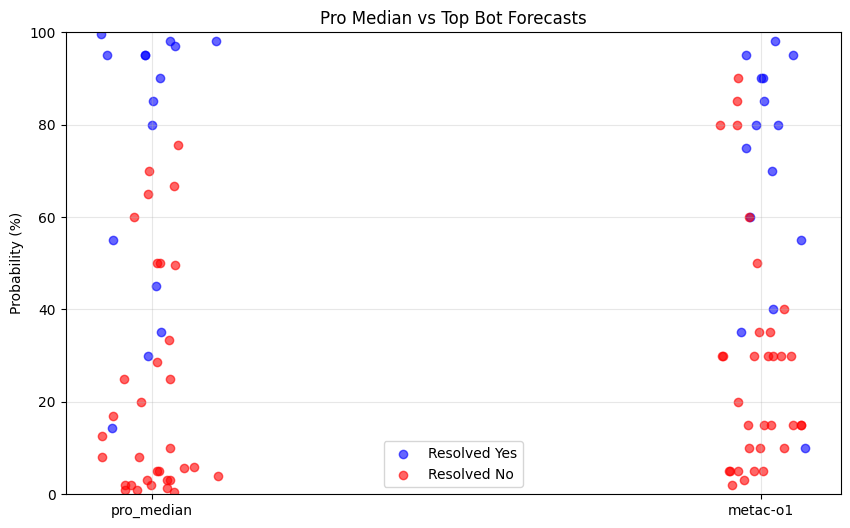

In [198]:
# Average pro median forecast on questions that resolved yes/no vs top bot

top_bot = leaderboard['bot'][1]

resolved_yes = df_pro_bot_forecasts[df_pro_bot_forecasts['resolution'] == 'yes']
resolved_no = df_pro_bot_forecasts[df_pro_bot_forecasts['resolution'] == 'no']

# Calculate the average pro median forecast for questions that resolved yes
mean_pro_median_yes = resolved_yes['pro_median'].mean().round(2) * 100
mean_pro_median_no = resolved_no['pro_median'].mean().round(2) * 100

mean_bot_yes = resolved_yes[top_bot].mean().round(2) * 100
mean_bot_no = resolved_no[top_bot].mean().round(2) * 100

print(f'mean pro median forecast on questions that resolved yes: {mean_pro_median_yes}%')
print(f'mean pro median forecast on questions that resolved no: {mean_pro_median_no}%')
print(f'mean {top_bot} forecast on questions that resolved yes: {mean_bot_yes}%')
print(f'mean {top_bot} forecast on questions that resolved no: {mean_bot_no}%')

# Plot the data
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure
plt.figure(figsize=(10, 6))

# Create x-coordinates with jitter for each group separately
x_bot_yes = np.random.normal(0, 0.04, len(resolved_yes))
x_pro_yes = np.random.normal(1, 0.04, len(resolved_yes))
x_bot_no = np.random.normal(0, 0.04, len(resolved_no))
x_pro_no = np.random.normal(1, 0.04, len(resolved_no))

# Plot points for "yes" resolution
plt.scatter(x_bot_yes, resolved_yes['pro_median'] * 100,
           color='blue', alpha=0.6, label='Resolved Yes')
plt.scatter(x_pro_yes, resolved_yes[top_bot] * 100,
           color='blue', alpha=0.6)

# Plot points for "no" resolution
plt.scatter(x_bot_no, resolved_no['pro_median'] * 100,
           color='red', alpha=0.6, label='Resolved No')
plt.scatter(x_pro_no, resolved_no[top_bot] * 100,
           color='red', alpha=0.6)

# Customize the plot
plt.xticks([0, 1], ['pro_median', top_bot])
plt.ylabel('Probability (%)')
plt.title('Pro Median vs Top Bot Forecasts')
plt.legend()
plt.grid(True, alpha=0.3)

# Set y-axis limits from 0 to 100
plt.ylim(0, 100)

plt.show()

In [199]:
bot_vs_pro_peer_for_scores = df_bot_vs_pro_peer.copy()
bot_vs_pro_peer_for_scores = bot_vs_pro_peer_for_scores.drop(['resolution', 'question_weight', 'bot_question_id', 'pro_median', 'options', 'type'], axis=1)

total_scores = bot_vs_pro_peer_for_scores.sum(axis=0)

df_bot_vs_pro_peer = df_bot_vs_pro_peer.drop('pro_median', axis=1)

# First pivot to long format - each row will be a question-forecaster pair
df_long = df_bot_vs_pro_peer.melt(
    id_vars=['bot_question_id', 'pro_question_id', 'question_weight', 'resolution', 'type', 'options'],
    var_name='forecaster',
    value_name='score'
)

# Drop any rows where score is NaN
df_long = df_long.dropna(subset=['score'])

# Cast question_weight as numeric
df_long['question_weight'] = pd.to_numeric(df_long['question_weight'], errors='coerce')

# Group first, then do the multiplication and sum
weighted_scores = df_long.groupby('forecaster').apply(lambda x: (x['score'] * x['question_weight']).sum(axis=0))

# Calculate number of questions answered by each bot
num_questions = df_long.groupby('forecaster')['bot_question_id'].nunique()
#num_weighted_questions = df_bot_vs_pro_peer.mul(df_pro_bot_forecasts['question_weight'], axis=0).apply(lambda col: col[col.notna() & col.apply(np.isreal)].count())

# Create a new DataFrame with the results
results = pd.DataFrame({
    'Peer_vs_Pro': total_scores,
    'Count': num_questions
})

weighted_results = pd.DataFrame({
    'W_Peer_vs_Pro': weighted_scores,
    'Count': num_questions
})

df_bot_vs_pro_leaderboard = results.sort_values(by='Peer_vs_Pro', ascending=False)
df_bot_vs_pro_weighted_leaderboard = weighted_results.sort_values(by='W_Peer_vs_Pro', ascending=False)

/tmp/ipykernel_739597/946735765.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_scores = df_long.groupby('forecaster').apply(lambda x: (x['score'] * x['question_weight']).sum(axis=0))


In [200]:
df_pro_baseline = df_pro_baseline.rename(columns={'question_id': 'pro_question_id'})
df_pro_baseline = df_pro_baseline[['pro_question_id', 'forecaster', 'score']]

# Now make it wide! forecaster = columns; score = values; index = pro_question_id
df_pro_baseline_wide = df_pro_baseline.pivot(index='pro_question_id', columns='forecaster', values='score').reset_index()

In [201]:
# @title Create df_pro_bot_baseline_leaderboard, df_pro_bot_baseline_weighted_leaderboard

df_pro_bot_baseline_weights = pd.merge(
    df_pro_bot_resolved_questions,
    df_bot_baseline_wide,
    on='bot_question_id',
    how='left'
)

df_pro_bot_baseline_weights = pd.merge(
    df_pro_bot_baseline_weights,
    df_pro_baseline_wide[['pro_question_id', 'pro_median']],
    on='pro_question_id',
    how='left'
)

# Remove rows where pro_question_id is NaN (only want overlapping questions here)
df_pro_bot_baseline_weights = df_pro_bot_baseline_weights.dropna(subset=['pro_question_id'])

# Create a list of columns to keep
forecaster_cols = ['pro_median'] + [col for col in df_pro_bot_baseline_weights.columns if col in all_bots]
df_filtered = df_pro_bot_baseline_weights[forecaster_cols]

# Calculate the sum for each forecaster
forecaster_scores = df_filtered.sum()
forecaster_weighted_scores = df_filtered.mul(df_pro_bot_baseline_weights['question_weight'], axis=0).sum()

question_counts = df_filtered.notna().sum()
question_weighted_counts = df_filtered.notna().mul(df_pro_bot_baseline_weights['question_weight'], axis=0).sum()

# Create a DataFrame for the leaderboard
leaderboard = pd.DataFrame({
    'Forecaster': forecaster_scores.index,
    'Baseline': forecaster_scores.values,
    'Count': question_counts.values
})

# Create a DataFrame for the leaderboard
weighted_leaderboard = pd.DataFrame({
    'Forecaster': forecaster_weighted_scores.index,
    'Weighted_Baseline': forecaster_weighted_scores.values,
    'Count': question_counts.values,
    'Weighted Count': question_weighted_counts.values
})

# Sort the leaderboard by score in descending order
leaderboard = leaderboard.sort_values('Baseline', ascending=False).reset_index(drop=True)
weighted_leaderboard = weighted_leaderboard.sort_values('Weighted_Baseline', ascending=False).reset_index(drop=True)

# Add a 'Rank' column
leaderboard['Rank'] = leaderboard.index + 1
weighted_leaderboard['Rank'] = weighted_leaderboard.index + 1

# Reorder columns to have Rank first
leaderboard = leaderboard[['Rank', 'Forecaster', 'Baseline', 'Count']]
weighted_leaderboard = weighted_leaderboard[['Rank', 'Forecaster', 'Weighted_Baseline', 'Count', 'Weighted Count']]

#leaderboard
weighted_leaderboard

,Rank,Forecaster,Weighted_Baseline,Count,Weighted Count
0,1,pro_median,4238.561607,97,93.10
1,2,metac-o1,3010.353788,96,92.10
2,3,metac-perplexity,2774.080331,94,90.10
3,4,bot_median,2273.115089,97,93.10
4,5,acm_bot,2239.058675,85,81.25
5,6,metac-claude-3-5-sonnet-20240620,2018.110211,95,91.50
6,7,manticAI,1865.126260,74,70.45
7,8,metac-exa,1826.275681,94,90.10
8,9,twsummerbot,1819.064141,62,59.40
9,10,metac-claude-3-5-sonnet-latest,1740.315188,96,92.10


In [202]:
# make me a list that's pro_median and all the bot forecasters
forecasters = ['pro_median'] + [col for col in df_pro_bot_baseline_weights.columns if col in all_bots]

hey = calculate_t_test(df_pro_bot_baseline_weights, forecasters)

hey

,W_score,W_count,W_ave,W_stdev,std_err,t_stat,t_crit,upper_bound,lower_bound,cdf,p_value
pro_median,4238.6,93.1,45.5,62.229168,6.449398,7.059105,1.985277,58.3,32.7,1.000000,0.000000
metac-o1,3010.4,92.1,32.7,57.756859,6.018299,5.431054,1.985550,44.6,20.7,1.000000,0.000000
metac-perplexity,2774.1,90.1,30.8,67.210383,7.080664,4.348308,1.986114,44.9,16.7,0.999982,0.000036
bot_median,2273.1,93.1,24.4,58.936587,6.108156,3.997253,1.985277,36.5,12.3,0.999935,0.000129
acm_bot,2239.1,81.2,27.6,55.554054,6.163169,4.471343,1.988985,39.8,15.3,0.999987,0.000025
metac-claude-3-5-sonnet-20240620,2018.1,91.5,22.1,64.219307,6.713594,3.285252,1.985788,35.4,8.7,0.999275,0.001450
manticAI,1865.1,70.4,26.5,66.353059,7.905338,3.348936,1.993488,42.2,10.7,0.999343,0.001314
metac-exa,1826.3,90.1,20.3,82.219585,8.661894,2.340069,1.986114,37.5,3.1,0.989243,0.021514
twsummerbot,1819.1,59.4,30.6,54.747799,7.103517,4.311100,2.000163,44.8,16.4,0.999968,0.000063
metac-claude-3-5-sonnet-latest,1740.3,92.1,18.9,71.545983,7.455134,2.534620,1.985550,33.7,4.1,0.993518,0.012963


In [203]:
# @title Weighted head-to-head, T test

"""
df_W_leaderboard: A leaderboard based on df_bot_vs_pro_peer with question
weighting and the calculations for doing a weighted T test
"""

forecaster_weighted_scores = forecaster_weighted_scores.fillna(0)

# Cast weights as numeric
df_bot_vs_pro_peer['question_weight'] = pd.to_numeric(df_bot_vs_pro_peer['question_weight'], errors='coerce')

# Calculate weighted statistics for each bot
df_W_leaderboard = calculate_t_test(df_bot_vs_pro_peer, all_bots)

df_W_leaderboard

/home/benwilson/Desktop/LogipediaStuff/aib-analysis/functions.py:525: RuntimeWarning: divide by zero encountered in scalar divide
  t_statistic = (weighted_average - 0) / std_error
/home/benwilson/Desktop/LogipediaStuff/aib-analysis/functions.py:525: RuntimeWarning: divide by zero encountered in scalar divide
  t_statistic = (weighted_average - 0) / std_error
/home/benwilson/Desktop/LogipediaStuff/aib-analysis/functions.py:525: RuntimeWarning: divide by zero encountered in scalar divide
  t_statistic = (weighted_average - 0) / std_error
/home/benwilson/Desktop/LogipediaStuff/aib-analysis/functions.py:525: RuntimeWarning: divide by zero encountered in scalar divide
  t_statistic = (weighted_average - 0) / std_error
/home/benwilson/Desktop/LogipediaStuff/aib-analysis/functions.py:525: RuntimeWarning: divide by zero encountered in scalar divide
  t_statistic = (weighted_average - 0) / std_error
/home/benwilson/Desktop/LogipediaStuff/aib-analysis/functions.py:525: RuntimeWarning: divide by

,W_score,W_count,W_ave,W_stdev,std_err,t_stat,t_crit,upper_bound,lower_bound,cdf,p_value
metac-perplexity,1719.7,95.0,18.1,3.570999e-15,3.663768e-16,4.940951e+16,1.98475,18.1,18.1,1.0,0.000000
acm_bot,1680.6,95.0,17.7,3.570999e-15,3.663768e-16,4.828449e+16,1.98475,17.7,17.7,1.0,0.000000
bot_median,1610.4,95.0,17.0,3.570999e-15,3.663768e-16,4.626691e+16,1.98475,17.0,17.0,1.0,0.000000
metac-o1,1577.6,95.0,16.6,3.570999e-15,3.663768e-16,4.532462e+16,1.98475,16.6,16.6,1.0,0.000000
metac-claude-3-5-sonnet-20240620,1405.9,95.0,14.8,3.570999e-15,3.663768e-16,4.039354e+16,1.98475,14.8,14.8,1.0,0.000000
manticAI,1378.2,95.0,14.5,0.000000e+00,0.000000e+00,inf,1.98475,14.5,14.5,1.0,0.000000
twsummerbot,1355.4,95.0,14.3,1.785500e-15,1.831884e-16,7.788325e+16,1.98475,14.3,14.3,1.0,0.000000
jkraybill_bot,1354.5,95.0,14.3,1.785500e-15,1.831884e-16,7.783286e+16,1.98475,14.3,14.3,1.0,0.000000
metac-exa,1233.6,95.0,13.0,1.785500e-15,1.831884e-16,7.088710e+16,1.98475,13.0,13.0,1.0,0.000000
GreeneiBot2,1163.2,95.0,12.2,0.000000e+00,0.000000e+00,inf,1.98475,12.2,12.2,1.0,0.000000


In [204]:
# Write to csv
df_W_leaderboard.to_csv('notebook_outputs/weighted_t_test_h2h_bot_vs_pros.csv', index=True)

In [205]:
# @title Weighted Bot Peer, T test (to compare bots against each other, use ALL QUESTIONS)

df_W_bot_peer_leaderboard = pd.DataFrame()

df3 = pd.DataFrame()

forecaster_weighted_scores = forecaster_weighted_scores.fillna(0)

# OMIT bot_median column for this bit
df_bot_peer_wide_b = df_bot_peer_wide.drop('bot_median', axis=1)
df_bot_peer = df_bot_peer[df_bot_peer['forecaster'] != 'bot_median']

bots_for_peer = np.array(list(set(df_bot_peer['forecaster'])))

df_W_leaderboard = calculate_t_test(df_bot_peer_wide_b, bots_for_peer)

df_W_leaderboard_print = df_W_leaderboard.sort_values(by='lower_bound', ascending=False)
df_W_leaderboard_print['Rank'] = range(1, len(df_W_leaderboard_print) + 1)

# Make index into a column - Bot
df_W_leaderboard_print = df_W_leaderboard_print.reset_index()
df_W_leaderboard_print = df_W_leaderboard_print.rename(columns={'index': 'Bot'})
#df_W_leaderboard_print = df_W_leaderboard_print[['Rank', 'Bot', 'W_ave', 'W_count', 'lower_bound', 'upper_bound']]
# Make rank the first column; leave rest the same
cols = df_W_leaderboard_print.columns.tolist()
cols = ['Rank'] + cols[:-1]
df_W_leaderboard_print = df_W_leaderboard_print[cols]

df_W_leaderboard_print

,Rank,Bot,W_score,W_count,W_ave,W_stdev,std_err,t_stat,t_crit,upper_bound,lower_bound,cdf,p_value
0,1,metac-o1,3631.1,375.3,9.7,35.071140,1.810294,5.344293,1.965985,13.2,6.1,1.000000,0.000000
1,2,metac-o1-preview,3121.4,368.7,8.5,45.961589,2.393573,3.536820,1.966093,13.2,3.8,0.999772,0.000457
2,3,metac-Gemini-Exp-1206,1880.5,347.1,5.4,44.895844,2.409719,2.248133,1.966458,10.2,0.7,0.987402,0.025197
3,4,SynapseSeer,966.5,152.0,6.4,35.699215,2.895113,2.195568,1.974879,12.1,0.6,0.985176,0.029648
4,5,manticAI,2055.2,315.7,6.5,55.690063,3.134498,2.077154,1.967187,12.7,0.3,0.980701,0.038598
5,6,twsummerbot,1450.0,241.3,6.0,45.091140,2.902709,2.070153,1.969313,11.7,0.3,0.980247,0.039507
6,7,acm_bot,1738.4,344.8,5.0,45.846332,2.469143,2.042154,1.966521,9.9,0.2,0.979051,0.041899
7,8,cookics_bot_TEST,1143.8,162.6,7.0,46.796454,3.669887,1.916829,1.974138,14.3,-0.2,0.971488,0.057024
8,9,CumulativeBot,991.4,104.5,9.5,52.180325,5.104446,1.858584,1.982136,19.6,-0.6,0.967036,0.065928
9,10,metac-claude-3-5-sonnet-latest,951.3,370.3,2.6,38.263066,1.988342,1.291954,1.966063,6.5,-1.3,0.901410,0.197181


In [206]:
# Write to csv
df_W_leaderboard_print.to_csv('notebook_outputs/weighted_bot_peer_leaderboard_t_test.csv', index=False)

In [207]:
df_bot_peer_wide.head()

,bot_question_id,4Shadower,Bot_Pepa,CatrachoCaster,CumulativeBot,GreeneiBot2,Grizeu_Bot,InstitutPelFutur,KevinTestBot,MWG,...,metac-o1-preview,metac-perplexity,minefrac1,mmBot,pgodzinai,pianobot,swingswish,twsummerbot,wunderplumb,question_weight
0,31262,NaN,NaN,NaN,NaN,-242.660874,135.575273,47.259183,NaN,NaN,...,-205.076095,121.194882,NaN,-242.660874,-198.879258,NaN,NaN,NaN,NaN,1.0
1,31263,NaN,NaN,NaN,NaN,-96.476789,-99.090018,-94.660371,NaN,NaN,...,7.951703,7.951703,NaN,55.819041,44.625993,NaN,NaN,NaN,NaN,1.0
2,31264,NaN,NaN,NaN,NaN,18.892980,23.948225,-86.527528,NaN,NaN,...,13.821518,13.821518,NaN,1.307071,17.305437,NaN,NaN,NaN,NaN,1.0
3,31274,NaN,NaN,2.076868,NaN,31.094531,4.282464,-28.806893,NaN,14.663415,...,6.442579,16.621639,NaN,8.559053,11.145899,NaN,NaN,-9.706540,NaN,1.0
4,31275,NaN,NaN,NaN,NaN,30.694891,-66.461608,-58.368696,NaN,NaN,...,35.698675,-0.691552,NaN,39.414502,14.411756,NaN,NaN,-70.932651,NaN,1.0


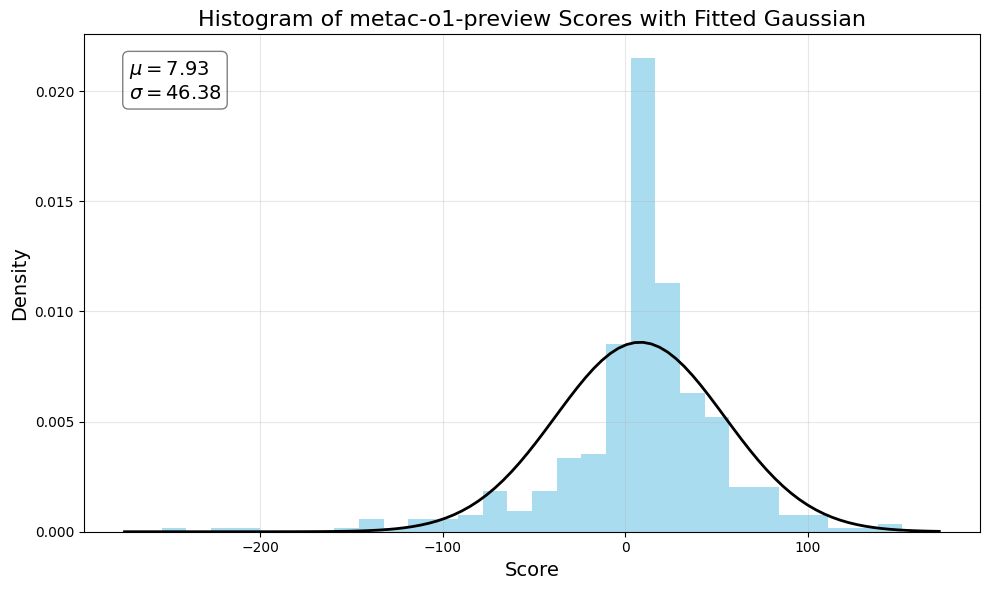

In [208]:
# @title Histogram of bot

if 'mf-bot-1' in df_bot_peer_wide.columns:
  name = 'mf-bot-1'
else:
  name = 'metac-o1-preview'

scores = df_bot_peer_wide[name].dropna()

# Create the histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(scores, bins=30, density=True, alpha=0.7, color='skyblue')

# Fit a normal distribution to the data
mu, std = norm.fit(scores)

# Plot the PDF of the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Customize the plot
plt.title(f"Histogram of {name} Scores with Fitted Gaussian", fontsize=16)
plt.xlabel("Score", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Add text box with distribution parameters
textstr = f'$\mu={mu:.2f}$\n$\sigma={std:.2f}$'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [209]:
df_bot_peer_wide.shape

display_head_and_tail(df_bot_peer_wide)

,bot_question_id,4Shadower,Bot_Pepa,CatrachoCaster,CumulativeBot,GreeneiBot2,Grizeu_Bot,InstitutPelFutur,KevinTestBot,MWG,...,metac-o1-preview,metac-perplexity,minefrac1,mmBot,pgodzinai,pianobot,swingswish,twsummerbot,wunderplumb,question_weight
0,31262,NaN,NaN,NaN,NaN,-242.660874,135.575273,47.259183,NaN,NaN,...,-205.076095,121.194882,NaN,-242.660874,-198.879258,NaN,NaN,NaN,NaN,1.0
1,31263,NaN,NaN,NaN,NaN,-96.476789,-99.090018,-94.660371,NaN,NaN,...,7.951703,7.951703,NaN,55.819041,44.625993,NaN,NaN,NaN,NaN,1.0
2,31264,NaN,NaN,NaN,NaN,18.892980,23.948225,-86.527528,NaN,NaN,...,13.821518,13.821518,NaN,1.307071,17.305437,NaN,NaN,NaN,NaN,1.0
3,31274,NaN,NaN,2.076868,NaN,31.094531,4.282464,-28.806893,NaN,14.663415,...,6.442579,16.621639,NaN,8.559053,11.145899,NaN,NaN,-9.706540,NaN,1.0
4,31275,NaN,NaN,NaN,NaN,30.694891,-66.461608,-58.368696,NaN,NaN,...,35.698675,-0.691552,NaN,39.414502,14.411756,NaN,NaN,-70.932651,NaN,1.0


,bot_question_id,4Shadower,Bot_Pepa,CatrachoCaster,CumulativeBot,GreeneiBot2,Grizeu_Bot,InstitutPelFutur,KevinTestBot,MWG,...,metac-o1-preview,metac-perplexity,minefrac1,mmBot,pgodzinai,pianobot,swingswish,twsummerbot,wunderplumb,question_weight
404,35619,6.356385,NaN,6.356385,8.985116,14.048951,-5.740252,6.356385,-5.740252,10.822423,...,-5.740252,6.356385,NaN,0.486061,13.624559,NaN,NaN,7.941684,6.356385,1.0
405,35620,-3.848478,NaN,2.026137,-2.646385,3.161815,-3.848478,11.301510,-3.848478,-23.803402,...,2.026137,2.026137,NaN,7.583046,8.230127,NaN,NaN,NaN,-3.848478,1.0
406,35621,34.934257,NaN,-15.681382,36.351904,-16.055800,-62.135408,-96.717277,34.934257,32.624547,...,9.104719,-48.411348,NaN,29.059642,31.449931,NaN,NaN,NaN,34.934257,1.0
407,35622,-58.153367,NaN,NaN,NaN,-14.351771,-85.428443,-29.096400,42.884269,NaN,...,78.874603,78.874603,NaN,114.533049,105.344243,NaN,NaN,-1.818274,-97.726020,1.0
408,35705,-31.742288,NaN,NaN,43.330777,50.023660,26.291942,NaN,-0.620330,22.674004,...,-37.061593,-0.620330,NaN,-8.601475,79.739445,NaN,NaN,NaN,10.305945,1.0


In [210]:
# Drop 'bot_median' from all_bots list
all_bots_wo_median = np.delete(all_bots, np.where(all_bots == 'bot_median')[0][0])
df_bot_peer_wide_wo_median = df_bot_peer_wide.drop('bot_median', axis=1)

NUM = round(df_bot_peer_wide['question_weight'].sum())
ITER = 1000

result_df = weighted_bootstrap_analysis(df_bot_peer_wide_wo_median, all_bots_wo_median, NUM, ITER)
average_df = result_df / NUM

print(f'BOT LEADERBOARD\n\n')
df_rounded = average_df.round(1)
df_rounded

BOT LEADERBOARD




,2.5% CI,10% CI,Median,90% CI,97.5% CI
metac-o1,6.1,7.4,9.7,12.0,13.1
metac-o1-preview,3.5,5.0,8.2,11.1,12.8
manticAI,0.3,2.1,5.4,8.6,10.4
metac-Gemini-Exp-1206,0.7,2.2,5.0,7.8,9.2
acm_bot,-0.1,1.4,4.6,7.6,9.2
metac-perplexity,-1.4,0.5,4.1,7.9,9.5
GreeneiBot2,-1.1,0.7,3.9,7.2,8.8
twsummerbot,0.1,1.5,3.9,6.1,7.4
cookics_bot_TEST,0.1,1.1,3.0,5.1,6.1
pgodzinai,-4.2,-1.3,2.9,7.0,9.0


In [211]:
NUM = round(df_bot_vs_pro_peer['question_weight'].sum())
ITER = 1000

result_df = weighted_bootstrap_analysis(df_bot_vs_pro_peer, all_bots, NUM, ITER)
average_df = result_df / NUM

print(f'\n\n\nHEAD-TO-HEAD LEADERBOARD\n\n')
#df_rounded = result_df.round(0).astype(int)
df_rounded = average_df.round(1)

df_rounded




HEAD-TO-HEAD LEADERBOARD




,2.5% CI,10% CI,Median,90% CI,97.5% CI
metac-perplexity,18.1,18.1,18.1,18.1,18.1
acm_bot,17.7,17.7,17.7,17.7,17.7
bot_median,17.0,17.0,17.0,17.0,17.0
metac-o1,16.6,16.6,16.6,16.6,16.6
metac-claude-3-5-sonnet-20240620,14.8,14.8,14.8,14.8,14.8
manticAI,14.5,14.5,14.5,14.5,14.5
twsummerbot,14.3,14.3,14.3,14.3,14.3
jkraybill_bot,14.3,14.3,14.3,14.3,14.3
metac-exa,13.0,13.0,13.0,13.0,13.0
GreeneiBot2,12.2,12.2,12.2,12.2,12.2


In [212]:
# Write df_rounded (bootstrapping h2h) to csv
df_rounded.to_csv('notebook_outputs/bootstrapped_h2h_bot_vs_pros.csv')

Weighted score for annabot: -190.5513637093994
Total score for annabot: 21.125669919166132



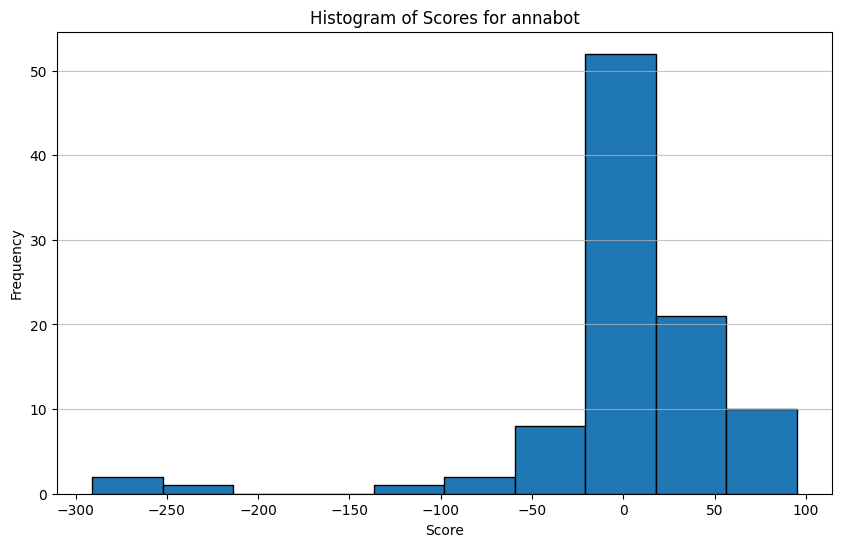

In [213]:
# @title Check specific bot records

bot_name = 'annabot'

df_bot = df_bot_peer_wide[['bot_question_id', 'question_weight', bot_name]]
df_bot = df_bot.dropna()
df_bot = df_bot.reset_index(drop=True)

df_bot['weighted_score'] = df_bot[bot_name] * df_bot['question_weight']

weighted_score = df_bot['weighted_score'].sum()

print(f"Weighted score for {bot_name}: {weighted_score}")

total_score = df_bot[bot_name].sum()

print(f"Total score for {bot_name}: {total_score}\n")

# Create the histogram
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.hist(df_bot[bot_name], bins=10, edgecolor='black')

# Customize the plot
plt.title(f'Histogram of Scores for {bot_name}')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Add grid lines (optional)
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()

In [214]:
# @title Weighted Bot Only Peer, T test

# To choose our top bot team, we only use the questions for which there is no Pro benchmark. (in Q4, there were some bots who ONLY forecasted on questions with Pro benchmark)
no_pro_benchmark = df_pro_bot_resolved_questions[df_pro_bot_resolved_questions['pro_question_id'].isna()]['bot_question_id']

df_bot_only_peer = df_bot_peer[df_bot_peer['bot_question_id'].isin(no_pro_benchmark)]
df_bot_only_peer_wide = make_wide(df_bot_only_peer, df_pro_bot_resolved_questions)

df_W_bot_only_peer_leaderboard = calculate_t_test(df_bot_only_peer_wide, df_bot_only_peer['forecaster'].unique())

df_W_bot_only_peer_leaderboard[['W_ave', 'W_count', 'lower_bound', 'upper_bound', 'p_value']].sort_values(by='lower_bound', ascending=False)

,W_ave,W_count,lower_bound,upper_bound,p_value
metac-o1-preview,12.2,276.6,7.1,17.3,0.000004
metac-o1,8.4,283.2,4.0,12.7,0.000179
pgodzinai,8.7,248.0,1.1,16.3,0.025267
GreeneiBot2,9.2,204.8,1.1,17.3,0.026930
manticAI,7.7,245.2,0.5,14.9,0.035671
acm_bot,5.4,263.5,-0.2,11.0,0.058135
metac-Gemini-Exp-1206,5.3,269.6,-0.3,10.8,0.062806
SynapseSeer,6.0,125.9,-0.5,12.5,0.068737
metac-claude-3-5-sonnet-latest,3.6,278.2,-0.9,8.2,0.116899
twsummerbot,4.9,181.9,-1.8,11.6,0.152393


In [215]:
df_W_bot_only_peer_leaderboard.to_csv('notebook_outputs/weighted_bot_ONLY_peer_leaderboard_t_test.csv', index=True)

In [216]:
# Sort the DataFrame by the lower_bound column in descending order
sorted_df = df_W_bot_only_peer_leaderboard.sort_values(by='lower_bound', ascending=False)

# exclude bot median for purposes of bot teaming
sorted_df = sorted_df.drop('bot_median', errors='ignore')

# Get the top 10 bot names
top_10_bots = sorted_df.index[:10].tolist()

# Print the list of top 10 bots
print("Top 10 bots:")
for i, bot in enumerate(top_10_bots, 1):
    print(f"{i}. {bot}")

Top 10 bots:
1. metac-o1-preview
2. metac-o1
3. pgodzinai
4. GreeneiBot2
5. manticAI
6. acm_bot
7. metac-Gemini-Exp-1206
8. SynapseSeer
9. metac-claude-3-5-sonnet-latest
10. twsummerbot


In [217]:
# @title Calculate df_bot_team_forecasts

df_bot_team_forecasts = pd.merge(
    df_bot_forecasts,
    df_pro_bot_resolved_questions[['bot_question_id', 'pro_question_id', 'question_weight', 'resolution', 'type', 'options', 'range_min', 'range_max']],
    on='bot_question_id',
    how='left'
)

# KEEP ONLY ROWS WHERE PRO_QUESTION_ID IS NA
df_bot_team_forecasts = df_bot_team_forecasts[~df_bot_team_forecasts['pro_question_id'].isna()]

columns_to_keep = ['bot_question_id', 'question_weight', 'resolution', 'type', 'options', 'range_min', 'range_max'] + top_10_bots

# Filter the DataFrame to keep only the specified columns
df_bot_team_forecasts = df_bot_team_forecasts[columns_to_keep]

df_bot_team_forecasts['options'] = df_bot_team_forecasts['options'].apply(parse_options_array)

# Calculate and add median forecasts for 1 to 10 bots
for i in range(1, 11):
    bots_subset = top_10_bots[:i]
    column_name = f'median_forecast_{i}_bots'
    df_bot_team_forecasts[column_name] = df_bot_team_forecasts.apply(lambda row: get_median_forecast(row, bots=bots_subset), axis=1)

   >>> Collected 1 forecasts: [0.05]
   >>> Collected 1 forecasts: [0.35]
   >>> Collected 1 forecasts: [0.9]
   >>> Collected 1 forecasts: [0.8]
   >>> Collected 1 forecasts: [0.1]
   >>> Collected 1 forecasts: [0.8]
   >>> Collected 1 forecasts: [0.7]
   >>> Collected 1 forecasts: [0.05]
   >>> Collected 1 forecasts: [0.05]
   >>> Collected 1 forecasts: [0.2]
   >>> Collected 1 forecasts: [0.2]
   >>> Collected 1 forecasts: [0.7]
   >>> Collected 1 forecasts: [0.05]
   >>> Collected 1 forecasts: [0.1]
   >>> Collected 1 forecasts: [0.1]
   >>> Collected 1 forecasts: [0.15]
   >>> Collected 1 forecasts: [0.95]
   >>> Collected 1 forecasts: [0.1]
   >>> Collected 1 forecasts: [0.02]
   >>> Collected 1 forecasts: [0.05]
   >>> Collected 1 forecasts: [0.25]
   >>> Collected 1 forecasts: [0.3]
   >>> Collected 1 forecasts: [0.2]
   >>> Collected 1 forecasts: [0.98]
   >>> Collected 1 forecasts: [0.4]
   >>> Collected 1 forecasts: [0.35]
   >>> Collected 1 forecasts: [0.3]
   >>> Collected

In [218]:
# Cut off output in dataframes when a CELL is too long
pd.set_option('display.max_colwidth', 50)

In [219]:
df_bot_team_forecasts[['type', 'options', 'resolution', 'metac-o1-preview', 'median_forecast_5_bots', 'median_forecast_8_bots']]

,type,options,resolution,metac-o1-preview,median_forecast_5_bots,median_forecast_8_bots
0,multiple_choice,"[0, 1, 2-3, 4-6, >6]",0,"[0.014083333333333333,0.6016666666666668,0.178...",0.014505,0.097463
1,numeric,NaN,86.82,"[0.05,0.0506666667,0.0513333333,0.052,0.052666...","[0.037750000000000006, 0.038250620225000004, 0...","[0.0402, 0.040750496180000005, 0.04130456232, ..."
2,binary,NaN,no,0.05,0.063,0.085
3,multiple_choice,"[0-4, 5-9, >9]",5-9,"[0.15,0.65,0.2]",0.56,0.56
4,numeric,NaN,119.2,"[0.0,0.004,0.008,0.012,0.016,0.02,0.024,0.028,...","[0.0, 0.00207778844, 0.00416103382, 0.00624884...","[0.0, 0.002104582785714286, 0.0042130633714285..."
...,...,...,...,...,...,...
342,binary,NaN,yes,0.9,0.905,0.9025
351,binary,NaN,no,0.9,0.3,0.1835
355,binary,NaN,yes,0.95,0.8,0.8
361,binary,NaN,no,0.85,0.8,0.755


In [220]:
# Sanity check
a = df_bot_team_forecasts['question_weight'].sum()
b = df_bot_team_forecasts.shape[0] # number of rows in df_bot_team_forecasts
print(f'Sum of weights: {a}, Number of questions: {b}')

Sum of weights: 95.0, Number of questions: 99


In [221]:
# @title Calculate the baseline scores for each team size

teams = ['median_forecast_1_bots',
         'median_forecast_2_bots',
         'median_forecast_3_bots',
         'median_forecast_4_bots',
         'median_forecast_5_bots',
         'median_forecast_6_bots',
         'median_forecast_7_bots',
         'median_forecast_8_bots',
         'median_forecast_9_bots',
         'median_forecast_10_bots']

weighted_scores = calculate_weighted_scores(df_bot_team_forecasts, teams)

# Print nicely - round to 2 decimal places and first column should be just an integer (bot team size)
weighted_scores_print = pd.DataFrame(weighted_scores).reset_index()
weighted_scores_print.columns = ['Bot_Team_Size', 'Weighted_Baseline_Score_for_Bot_Team_Median']
weighted_scores_print['Weighted_Baseline_Score_for_Bot_Team_Median'] = weighted_scores_print['Weighted_Baseline_Score_for_Bot_Team_Median'].round(2)
weighted_scores_print['Bot_Team_Size'] = weighted_scores_print['Bot_Team_Size'].apply(lambda x: int(x.split('_')[2].split('_')[0]))
weighted_scores_print

,Bot_Team_Size,Weighted_Baseline_Score_for_Bot_Team_Median
0,1,18.17
1,2,24.94
2,3,26.48
3,4,26.48
4,5,26.77
5,6,26.92
6,7,25.83
7,8,26.50
8,9,25.22
9,10,25.45


In [222]:
# Index of top bot team from weighted_scores_print?
winning_bot_team_size = weighted_scores_print.sort_values(by='Weighted_Baseline_Score_for_Bot_Team_Median', ascending=False).head(1)['Bot_Team_Size'].values[0]
top_bot_team = top_10_bots[:winning_bot_team_size]
top_bot_team

['metac-o1-preview',
 'metac-o1',
 'pgodzinai',
 'GreeneiBot2',
 'manticAI',
 'acm_bot']

In [223]:
df_bot_forecasts.shape

(424, 47)

In [224]:
# Merge bot_team_forecasts with df_top_bot_forecasts, just get type and options columns from bot_team_forecasts, merge on bot_question_id
df_bot_forecasts = pd.merge(
    df_bot_forecasts,
    df_bot_team_forecasts[['bot_question_id', 'type', 'options', 'resolution']],
    on='bot_question_id',
    how='left'
)

# And make bot_question_id, type and options the first columns
df_bot_forecasts = df_bot_forecasts[['bot_question_id', 'type', 'options', 'resolution'] + [col for col in df_bot_forecasts.columns if col not in ['bot_question_id', 'type', 'options']]]

In [225]:
df_bot_team_forecasts.head()

,bot_question_id,question_weight,resolution,type,options,range_min,range_max,metac-o1-preview,metac-o1,pgodzinai,...,median_forecast_1_bots,median_forecast_2_bots,median_forecast_3_bots,median_forecast_4_bots,median_forecast_5_bots,median_forecast_6_bots,median_forecast_7_bots,median_forecast_8_bots,median_forecast_9_bots,median_forecast_10_bots
0,31262,1.0,0,multiple_choice,"[0, 1, 2-3, 4-6, >6]",NaN,NaN,"[0.014083333333333333,0.6016666666666668,0.178...","[0.4,0.3,0.2,0.05,0.05]","[0.014925742574257425,0.5137871287128712,0.334...",...,0.014083,0.207042,0.014926,0.014505,0.014505,0.014926,0.097463,0.097463,0.014926,0.014926
1,31263,1.0,86.82,numeric,NaN,60.0,100.0,"[0.05,0.0506666667,0.0513333333,0.052,0.052666...","[0.05,0.0506666667,0.0513333333,0.052,0.052666...","[0.001,0.001060875,0.0011396,0.0012863125,0.00...",...,"[0.05, 0.0506666667, 0.0513333333, 0.052, 0.05...","[0.05, 0.0506666667, 0.0513333333, 0.052, 0.05...","[0.03366666666666667, 0.0341314028, 0.03460208...","[0.037750000000000006, 0.038250620225000004, 0...","[0.037750000000000006, 0.038250620225000004, 0...","[0.0402, 0.040750496180000005, 0.04130456232, ...","[0.0402, 0.040750496180000005, 0.04130456232, ...","[0.0402, 0.040750496180000005, 0.04130456232, ...","[0.041833333333333333, 0.042403191266666675, 0...","[0.041833333333333333, 0.042403191266666675, 0..."
2,31264,1.0,no,binary,NaN,NaN,NaN,0.05,0.1,0.07,...,0.05,0.075,0.07,0.063,0.063,0.07,0.085,0.085,0.1,0.1
3,31274,1.0,5-9,multiple_choice,"[0-4, 5-9, >9]",NaN,NaN,"[0.15,0.65,0.2]","[0.29,0.56,0.14999999999999997]","[0.27499999999999997,0.5125,0.21249999999999997]",...,0.65,0.605,0.56,0.59,0.56,0.53625,0.56,0.56,0.53625,0.5125
4,31275,1.0,119.2,numeric,NaN,0.0,400.0,"[0.0,0.004,0.008,0.012,0.016,0.02,0.024,0.028,...","[0.0,0.0033333333,0.0066666667,0.01,0.01333333...","[0.0,0.0001141583,0.0002446967,0.0003862688,0....",...,"[0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024,...","[0.0, 0.00366666665, 0.00733333335, 0.011, 0.0...","[0.0, 0.0024824972, 0.004970454466666667, 0.00...","[0.0, 0.00231641835, 0.00463693175, 0.00696020...","[0.0, 0.00207778844, 0.00416103382, 0.00624884...","[0.0, 0.002038679916666667, 0.0040819072666666...","[0.0, 0.002104582785714286, 0.0042130633714285...","[0.0, 0.002104582785714286, 0.0042130633714285...","[0.0, 0.0023970654875000003, 0.0047975415625, ...","[0.0, 0.002276496766666667, 0.0045560251555555..."


In [226]:
# @title Weighted team-vs-pro

# We have our top bot team members.
# Calculate their median forecast on the pro_bot questions.
# Create df with bot_question_id, forecasts, resolution, weights
# Calculate the head-to-head score

df_top_bot_forecasts = df_bot_team_forecasts[['bot_question_id', f'median_forecast_{len(top_bot_team)}_bots']]
df_top_bot_forecasts = df_top_bot_forecasts.rename(columns={f'median_forecast_{len(top_bot_team)}_bots': 'bot_team_median'})

df_pro_median = df_pro_forecasts[['pro_question_id', 'pro_median']]

df_top_bot_pro_forecasts = pd.merge(
    df_pro_bot_resolved_questions,
    df_top_bot_forecasts[['bot_question_id', 'bot_team_median']],
    on='bot_question_id',
    how='left'
)

df_top_bot_pro_forecasts = pd.merge(
    df_top_bot_pro_forecasts,
    df_pro_median,
    on='pro_question_id',
    how='left'
)

# Copy with union (not just overlapping questions)
df_top_bot_pro_forecasts_all = df_top_bot_pro_forecasts.copy()

# Filter to only those rows where pro_median is not NA
df_top_bot_pro_forecasts = df_top_bot_pro_forecasts.dropna(subset=['pro_median'])

# Add the head_to_head column
df_top_bot_pro_forecasts['head_to_head'] = df_top_bot_pro_forecasts.apply(calculate_head_to_head, args=('bot_team_median', 'pro_median'), axis=1)

In [227]:
weighted_total_score = get_weighted_score(df_top_bot_pro_forecasts)

Weighted Total Score: -15.6339


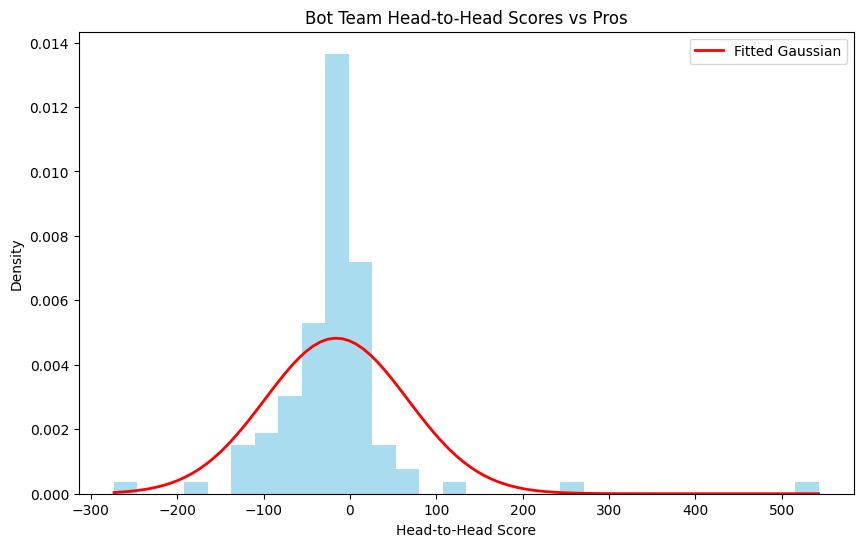

The average of 'head_to_head' is: -15.85


In [228]:
plot_head_to_head_distribution(df_top_bot_pro_forecasts)

In [229]:
df_bot_team_h2h = calculate_t_test(df_top_bot_pro_forecasts, ['head_to_head'])

df_bot_team_h2h

,W_score,W_count,W_ave,W_stdev,std_err,t_stat,t_crit,upper_bound,lower_bound,cdf,p_value
head_to_head,-1485.2,93.1,-16.0,84.368029,8.743857,-1.824475,1.985277,1.4,-33.3,0.035661,0.071323


In [230]:
pd.set_option('display.max_colwidth', 50)

df_sorted = df_top_bot_pro_forecasts.sort_values(by='head_to_head')
df_sorted['head_to_head'] = df_sorted['head_to_head'].round(1)
#df_sorted['resolution'] = df_sorted['resolution'].map({1: 'yes', 0: 'no'})

df_top5 = df_sorted.head(5)
df_bottom5 = df_sorted.tail(5)

print("Top 5:")

df_top5[['title', 'bot_team_median', 'pro_median', 'resolution', 'head_to_head']]

Top 5:


,title,bot_team_median,pro_median,resolution,head_to_head
279,What will Kalshi's rank in the iPhone Top Free...,0.058,"[0.02,0.01,0.015,0.015,0.05,0.89]",Not in top 50,-273.1
121,How many movies will be new on Netflix's top 1...,0.125,"[0.005,0.017,0.157,0.821]",3 or more,-188.2
47,"What will be Donald Trump's net worth, accordi...",0.17,"[0.6,0.2,0.1,0.075,0.025]","0-$6 billion, inclusive",-126.1
71,"Will OpenAI, Anthropic, or Perplexity run an a...",0.16,0.55,yes,-123.5
247,Will the 500th richest person on Bloomberg's B...,0.8,0.333,no,-120.4


In [ ]:
print("\nBottom 5:")

df_bottom5[['title', 'bot_team_median', 'pro_median', 'resolution', 'head_to_head']]


Bottom 5:


,title,bot_team_median,pro_median,resolution,head_to_head
85,Will Elon Musk attend the Super Bowl in 2025?,0.1685,0.755,no,122.2
0,"For Q1 2025, how many banks will be listed on ...",0.014926,"[0.001,0.62,0.35,0.019,0.01]",0,270.3
189,What will the highest rank of metac-GPT4o or m...,"[0.0, 0.016687996933333334, 0.0361674514166666...","[0.0,5.19918e-05,0.0001040776,0.0001562618,0.0...",34.0,542.5
211,Will Nikola Corporation file for bankruptcy be...,0.99,0.999,annulled,NaN
214,Will the state of Rhode Island have any recrea...,0.941,0.95,annulled,NaN


In [232]:
# Cast df_top_bot_pro_forecasts['resolution'] as string - idk why this is necessary but it is
df_top_bot_pro_forecasts['resolution'] = df_top_bot_pro_forecasts['resolution'].astype(pd.StringDtype())
df_top_bot_pro_forecasts['resolution'] = df_top_bot_pro_forecasts['resolution'].map({'yes': 1, 'no': 0})
df_top_bot_pro_forecasts.dtypes

bot_question_id                  Int64
title                           object
resolution                     float64
scheduled_close_time    datetime64[ns]
actual_close_time       datetime64[ns]
type                            object
options                         object
range_min                      float64
range_max                      float64
pro_question_id                  Int64
question_weight                float64
bot_team_median                 object
pro_median                      object
head_to_head                   float64
weighted_score                 float64
dtype: object

In [233]:
df_top_bot_pro_forecasts.head()

,bot_question_id,title,resolution,scheduled_close_time,actual_close_time,type,options,range_min,range_max,pro_question_id,question_weight,bot_team_median,pro_median,head_to_head,weighted_score
0,31262,"For Q1 2025, how many banks will be listed on ...",NaN,2025-01-20 03:27:00,2025-01-20 03:27:00,multiple_choice,"[""0"",""1"",""2-3"",""4-6"","">6""]",NaN,NaN,31268,1.0,0.014926,"[0.001,0.62,0.35,0.019,0.01]",270.308741,270.308741
1,31263,What percentage of the vote will Alexander Luk...,NaN,2025-01-20 03:27:00,2025-01-20 03:27:00,numeric,NaN,60.0,100.0,31269,1.0,"[0.0402, 0.040750496180000005, 0.04130456232, ...","[0.0013749738,0.0014499743,0.001526641,0.00160...",-75.535832,-75.535832
2,31264,Will the bubble in the Magnificent Seven pop b...,0.0,2025-01-20 03:27:00,2025-01-20 03:27:00,binary,NaN,NaN,NaN,31270,1.0,0.07,0.013,-5.948545,-5.948545
3,31274,How many arms sales globally will the US State...,NaN,2025-01-21 11:42:00,2025-01-21 11:42:00,multiple_choice,"[""0-4"",""5-9"","">9""]",NaN,NaN,31280,1.0,0.53625,"[0.16,0.44,0.4]",19.782574,19.782574
4,31275,"How much will it rain in Brasília, Brazil in F...",NaN,2025-01-21 11:42:00,2025-01-21 11:42:00,numeric,NaN,0.0,400.0,31281,1.0,"[0.0, 0.002038679916666667, 0.0040819072666666...","[0.0,0.0005044914,0.0010323506,0.0015847475,0....",12.716305,12.716305


In [234]:
# Make binary-only df_top_bot_pro_forecasts for calibration curves etc
df_top_bot_pro_forecasts_binary = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['type'] == 'binary'].copy()

df_top_bot_pro_forecasts_all_binary = df_top_bot_pro_forecasts_all[df_top_bot_pro_forecasts_all['type'] == 'binary'].copy()

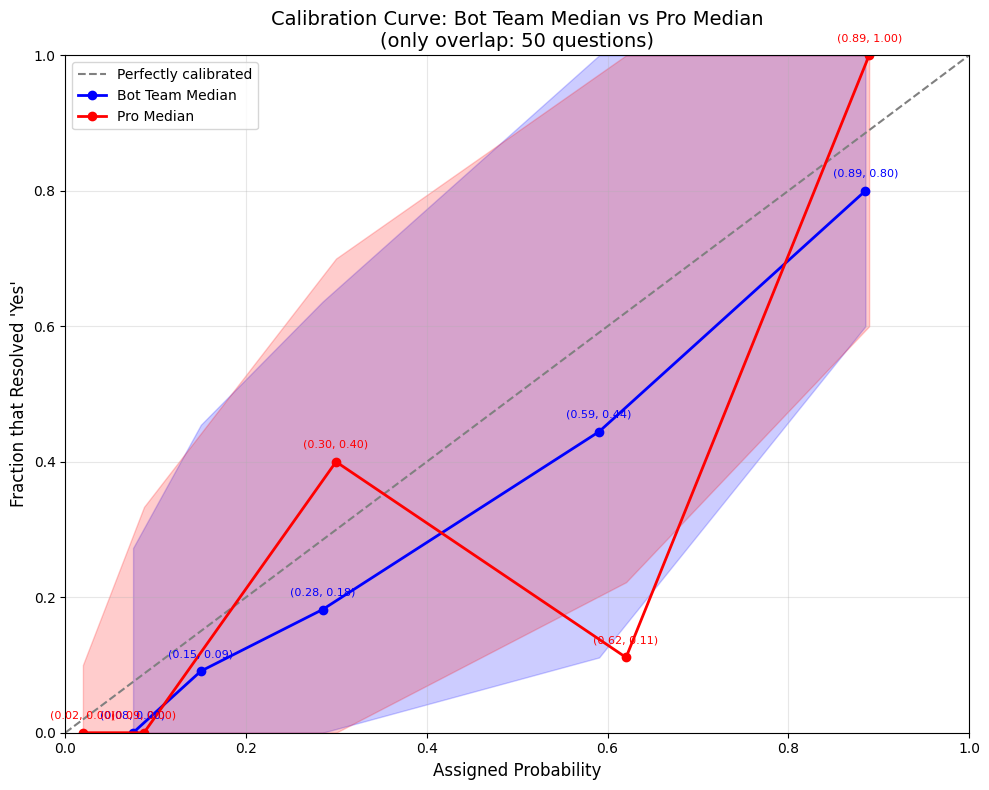

Number of pro forecasts: 50


In [235]:
# Set up the plot
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')

# Plot calibration curves for bot_team_median and pro_median
plot_calibration_curve(df_top_bot_pro_forecasts_binary, 'bot_team_median', 'Bot Team Median', 'blue')
plot_calibration_curve(df_top_bot_pro_forecasts_binary, 'pro_median', 'Pro Median', 'red')

# Customize the plot
plt.xlabel('Assigned Probability', fontsize=12)
plt.ylabel('Fraction that Resolved \'Yes\'', fontsize=12)
plt.title(f'Calibration Curve: Bot Team Median vs Pro Median\n(only overlap: {len(df_top_bot_pro_forecasts_binary)} questions)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Set axis limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Show the plot
plt.tight_layout()
plt.show()
print(f"Number of pro forecasts: {len(df_top_bot_pro_forecasts_binary)}")

In [236]:
# Map resolution to 0 and 1
df_top_bot_pro_forecasts_all_binary['resolution'] = df_top_bot_pro_forecasts_all_binary['resolution'].map({'yes': 1, 'no': 0})

In [237]:
df_top_bot_pro_forecasts_all_binary.head()

,bot_question_id,title,resolution,scheduled_close_time,actual_close_time,type,options,range_min,range_max,pro_question_id,question_weight,bot_team_median,pro_median
2,31264,Will the bubble in the Magnificent Seven pop b...,0.0,2025-01-20 03:27:00,2025-01-20 03:27:00,binary,NaN,NaN,NaN,31270,1.0,0.07,0.013
5,31276,Will the USDA-posted recall by Pork Dynasty In...,1.0,2025-01-21 11:42:00,2025-01-21 11:42:00,binary,NaN,NaN,NaN,31282,1.0,0.55,0.45
8,31288,Will Eric Adams be Mayor of New York City on t...,1.0,2025-01-22 20:19:00,2025-01-22 20:19:00,binary,NaN,NaN,NaN,31294,1.0,0.82,0.95
10,31318,Will the S&P 500 index go up in January 2025?,1.0,2025-01-23 23:23:00,2025-01-23 23:23:00,binary,NaN,NaN,NaN,<NA>,1.0,NaN,NaN
13,31334,"At the end of March 2025, will Wikipedia still...",1.0,2025-01-24 14:23:00,2025-01-24 14:23:00,binary,NaN,NaN,NaN,31338,1.0,0.825,0.9


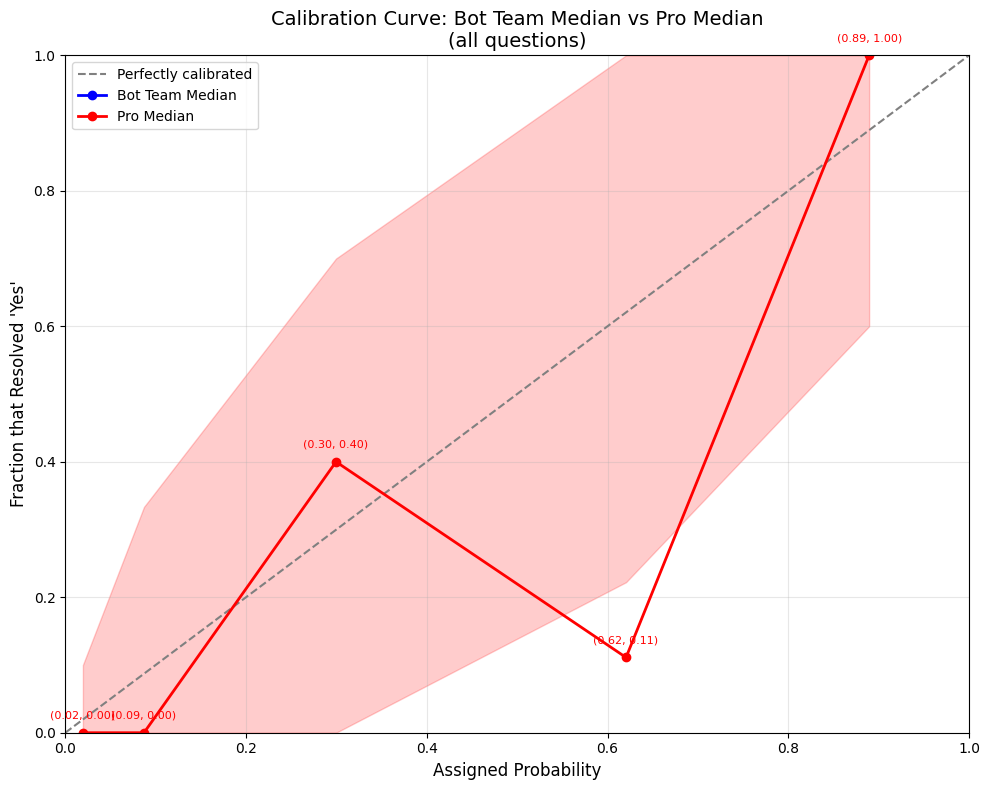

Number of pro forecasts: 50
Number of bot forecasts: 241


In [238]:
# Set up the plot
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')

# Plot calibration curves for bot_team_median and pro_median
plot_calibration_curve(df_top_bot_pro_forecasts_all_binary, 'bot_team_median', 'Bot Team Median', 'blue')
plot_calibration_curve(df_top_bot_pro_forecasts_binary, 'pro_median', 'Pro Median', 'red')

# Customize the plot
plt.xlabel('Assigned Probability', fontsize=12)
plt.ylabel('Fraction that Resolved \'Yes\'', fontsize=12)
plt.title(f'Calibration Curve: Bot Team Median vs Pro Median\n(all questions)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Set axis limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Show the plot
plt.tight_layout()
plt.show()
print(f"Number of pro forecasts: {len(df_top_bot_pro_forecasts_binary)}")
print(f"Number of bot forecasts: {len(df_top_bot_pro_forecasts_all_binary)}")

In [239]:
# Calculate confidence scores for bot_team_median and pro_median
display_head_and_tail(df_top_bot_pro_forecasts)
bot_confidence = calculate_confidence(df_top_bot_pro_forecasts['bot_team_median'], df_top_bot_pro_forecasts['resolution'])
pro_confidence = calculate_confidence(df_top_bot_pro_forecasts['pro_median'], df_top_bot_pro_forecasts['resolution'])

print(f"Bot team confidence score: {bot_confidence:.4f}")
print(f"Pro team confidence score: {pro_confidence:.4f}")

print(f"Bot team is {interpret_confidence(bot_confidence)}")
print(f"Pro team is {interpret_confidence(pro_confidence)}")

,bot_question_id,title,resolution,scheduled_close_time,actual_close_time,type,options,range_min,range_max,pro_question_id,question_weight,bot_team_median,pro_median,head_to_head,weighted_score
0,31262,"For Q1 2025, how many banks will be listed on ...",NaN,2025-01-20 03:27:00,2025-01-20 03:27:00,multiple_choice,"[""0"",""1"",""2-3"",""4-6"","">6""]",NaN,NaN,31268,1.0,0.014926,"[0.001,0.62,0.35,0.019,0.01]",270.308741,270.308741
1,31263,What percentage of the vote will Alexander Luk...,NaN,2025-01-20 03:27:00,2025-01-20 03:27:00,numeric,NaN,60.0,100.0,31269,1.0,"[0.0402, 0.040750496180000005, 0.04130456232, ...","[0.0013749738,0.0014499743,0.001526641,0.00160...",-75.535832,-75.535832
2,31264,Will the bubble in the Magnificent Seven pop b...,0.0,2025-01-20 03:27:00,2025-01-20 03:27:00,binary,NaN,NaN,NaN,31270,1.0,0.07,0.013,-5.948545,-5.948545
3,31274,How many arms sales globally will the US State...,NaN,2025-01-21 11:42:00,2025-01-21 11:42:00,multiple_choice,"[""0-4"",""5-9"","">9""]",NaN,NaN,31280,1.0,0.53625,"[0.16,0.44,0.4]",19.782574,19.782574
4,31275,"How much will it rain in Brasília, Brazil in F...",NaN,2025-01-21 11:42:00,2025-01-21 11:42:00,numeric,NaN,0.0,400.0,31281,1.0,"[0.0, 0.002038679916666667, 0.0040819072666666...","[0.0,0.0005044914,0.0010323506,0.0015847475,0....",12.716305,12.716305


,bot_question_id,title,resolution,scheduled_close_time,actual_close_time,type,options,range_min,range_max,pro_question_id,question_weight,bot_team_median,pro_median,head_to_head,weighted_score
342,35345,Will the US Citizenship and Immigration Servic...,1.0,2025-03-12 22:00:00,2025-03-12 22:00:00,binary,NaN,NaN,NaN,35380,1.00,0.92,0.95,-3.208831,-3.208831
351,35354,Will the United States impose any new tariffs ...,0.0,2025-03-13 03:00:00,2025-03-13 03:00:00,binary,NaN,NaN,NaN,35381,1.00,0.1775,0.05,-14.411350,-14.411350
355,35358,Will ChatGPT rank in the top 10 global website...,1.0,2025-03-13 03:00:00,2025-03-13 03:00:00,binary,NaN,NaN,NaN,35385,1.00,0.8,0.97,-19.268434,-19.268434
361,35364,Will Doge's Agency Efficiency Leaderboard have...,0.0,2025-03-14 23:00:00,2025-03-14 23:00:00,binary,NaN,NaN,NaN,35386,0.85,0.755,0.666,-30.988278,-26.340037
364,35367,Will the Project 2025 Tracker spreadsheet mark...,0.0,2025-03-14 23:00:00,2025-03-14 23:00:00,binary,NaN,NaN,NaN,35387,0.85,0.05,0.03,-2.083409,-1.770897


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# Call the function with your DataFrame and column names
create_discrimination_histogram(df_top_bot_pro_forecasts,
                                'bot_team_median',
                                'pro_median',
                                'resolution')

In [ ]:
# Calculate average forecasts for resolved 1 and 0 for bots
bot_avg_1 = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['resolution'] == 1]['bot_team_median'].mean()
bot_avg_0 = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['resolution'] == 0]['bot_team_median'].mean()

# Calculate average forecasts for resolved 1 and 0 for pros
pro_avg_1 = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['resolution'] == 1]['pro_median'].mean()
pro_avg_0 = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['resolution'] == 0]['pro_median'].mean()

# Calculate the differences
bot_difference = bot_avg_1 - bot_avg_0
pro_difference = pro_avg_1 - pro_avg_0

print(f"Bot average forecast difference (1 - 0): {bot_difference:.4f}")
print(f"Pro average forecast difference (1 - 0): {pro_difference:.4f}")

# Calculate the difference between pro and bot differences
pro_bot_difference = pro_difference - bot_difference
print(f"Difference between pro and bot differences: {pro_bot_difference:.4f}")

In [ ]:
# Calculate weighted number of 1 resolutions
weighted_ones = np.sum(
    df_top_bot_pro_forecasts['resolution'] *
    df_top_bot_pro_forecasts['question_weight']
)

# Calculate weighted number of 0 resolutions
weighted_zeros = np.sum(
    (1 - df_top_bot_pro_forecasts['resolution']) *
    df_top_bot_pro_forecasts['question_weight']
)

print(f"Weighted number of 1 resolutions: {weighted_ones}")
print(f"Weighted number of 0 resolutions: {weighted_zeros}")

print(f"Average 1 resolutions: {weighted_ones / (weighted_zeros + weighted_ones)}")

CP COMPARISON

In [ ]:
## CP COMPARISON

cp = pd.read_csv('https://data.heroku.com/dataclips/xwbtczmsuszvlbrhdifhsilplfxf.csv')
cp.rename(columns={'post_id': 'cp_post_id', 'question_id': 'cp_question_id'}, inplace=True)

bot_cp_id = pd.read_csv('misc_data/bot_to_main_feed_ids.csv')

# Merge these on cp_question_id
df_bot_cp = pd.merge(bot_cp_id, cp, on='cp_post_id', how='right') # ahh?

df_bot_cp = df_bot_cp[df_bot_cp['bot_question_id'].notnull()]
df_bot_cp['bot_question_id'] = df_bot_cp['bot_question_id'].astype(int)

# Evaluate cp_reveal_time, start_time, and end_time as datetime objects
df_bot_cp['cp_reveal_time'] = pd.to_datetime(df_bot_cp['cp_reveal_time'])
df_bot_cp['start_time'] = pd.to_datetime(df_bot_cp['start_time'])
df_bot_cp['end_time'] = pd.to_datetime(df_bot_cp['end_time'])

In [ ]:
# For each group of (bot_question_id, question_title, cp_reveal_time), take only the row with the start_time closest to (BUT LESS THAN) cp_reveal_time
df_bot_cp = df_bot_cp.sort_values(by=['bot_question_id', 'cp_reveal_time', 'start_time'])
df_bot_cp = df_bot_cp[df_bot_cp['start_time'] < df_bot_cp['cp_reveal_time']]
df_bot_cp = df_bot_cp.drop_duplicates(subset=['bot_question_id', 'cp_reveal_time', 'title'], keep='last')

## Convert string representation of lists to actual lists
df_bot_cp['forecast_values'] = df_bot_cp['forecast_values'].str.strip('[]').str.split(',').apply(lambda x: [float(i.strip()) for i in x])

In [ ]:
## Deal with influenza rows by filtering to rows where dates match.

# First do the December/November replacements only on the relevant rows
mask_29507 = df_bot_cp['cp_post_id'] == 29507
df_bot_cp.loc[mask_29507, 'title'] = df_bot_cp.loc[mask_29507, 'title'].str.replace('December', 'Dec', regex=False)
df_bot_cp.loc[mask_29507, 'title'] = df_bot_cp.loc[mask_29507, 'title'].str.replace('November', 'Nov', regex=False)

# Then filter only those rows by the date matching condition
matching_rows = df_bot_cp[mask_29507].apply(lambda row:
    row['title'].find(re.search(r'(\w+ \d+)', row['question_title']).group(1)) != -1,
    axis=1)

# Update only the matching rows within the 29507 subset
df_bot_cp = pd.concat([df_bot_cp[~mask_29507], df_bot_cp[mask_29507][matching_rows]])

In [ ]:
pd.set_option('display.max_colwidth', 250)

In [ ]:
# Break down by types - "group" (multiple choice; my bad), "binary" and "numeric"

# Group questions are the ones that have NON-EMPTY lists in the options column
groups = df_bot_cp[df_bot_cp['type'] == 'multiple_choice']
groups['options'] = groups['options'].str.strip('[]').str.split(',').apply(lambda x: [i.strip().strip("'") for i in x])

binaries = df_bot_cp[df_bot_cp['type'] == 'binary']

numerics = df_bot_cp[df_bot_cp['type'] == 'numeric']

keep_cols = ['bot_question_id', 'question_title', 'title', 'cp_reveal_time', 'type', 'cp_question_id', 'cp_post_id', 'resolution', 'forecast_values']

In [ ]:
# Find and store problematic index
problematic_idx = None
for idx, row in groups.iterrows():
   if len(row['forecast_values']) != len(row['options']):
       problematic_idx = idx
       break

# Fix the specific row using stored index
if problematic_idx is not None:
   groups.at[problematic_idx, 'options'] = [
       'Low',
       'Moderate (or medium or equivalent)',
       'High (or above such as Very High)'
   ]

In [ ]:
groups_exploded = groups.explode(['options', 'forecast_values'])
groups_exploded['options'] = groups_exploded['options'].str.strip('"')

mask = groups_exploded['question_title'].str.contains('Will Joe Biden sign', case=False, na=False)
groups_exploded.loc[mask, 'threshold'] = groups_exploded.loc[mask, 'question_title'].str.extract(r'(\d+)')[0]

In [ ]:
# For each bot_question_id
for bot_question_id in groups_exploded['bot_question_id'].unique():
    # Get all rows for this bot_question_id
    question_group = groups_exploded[groups_exploded['bot_question_id'] == bot_question_id]

    # Get the question title
    question_title = question_group['question_title'].iloc[0]

    # Function to check if option matches question title
    def option_matches(row):
        option = row['options']
        if option in question_title:
            return True
        # Handle "X or Y" vs "X-Y" format
        if '-' in option:
            start, end = option.split('-')
            or_format = f"{start} or {end}"
            return or_format in question_title
        return False

    # Find rows where the question title contains the option (with format handling)
    matching_rows = question_group[question_group.apply(option_matches, axis=1)]

    filtered_rows = []

    # If we found a matching row, add the first one to our filtered rows, EXCEPT... Biden
    if not matching_rows.empty and 'Biden' not in question_title:
        filtered_rows.append(matching_rows.iloc[0])

    # If Biden in question_title, we mustn't just take the first row - we must sum the rows that meet the threshold
    if 'Biden' in question_title:
        # Get first row for each unique option to avoid duplicates
        first_rows = matching_rows.drop_duplicates(subset=['options'])

        # Drop option='1' - we don't ask about 1 or more
        first_rows = first_rows[first_rows['options'] != '1']
        biden_interp = first_rows.copy()

        # Now for each row in biden_interp
        for idx, row in biden_interp.iterrows():
            threshold = int(row['threshold'])
            # Calculate cumulative probability based on that row's threshold
            if threshold == 2:
                forecast_value = first_rows[first_rows['options'].isin(['2', '3', '4 or more'])]['forecast_values'].sum()
            elif threshold == 3:
                forecast_value = first_rows[first_rows['options'].isin(['3', '4 or more'])]['forecast_values'].sum()
            elif threshold == 4:
                forecast_value = first_rows[first_rows['options'] == '4 or more']['forecast_values'].sum()

            # Update this row's forecast value
            biden_interp.at[idx, 'forecast_value'] = forecast_value

        filtered_rows.append(biden_interp.iloc[0])

# Combine all filtered rows into a DataFrame
groups_filtered = pd.DataFrame(filtered_rows)

# Print check
print(f"Original unique multiple-choice bot_question_ids: {len(groups_exploded['bot_question_id'].unique())}")
print(f"Filtered unique multiple-choice bot_question_ids: {len(groups_filtered['bot_question_id'].unique())}")

In [ ]:
# Show me Biden rows in groups_exploded
groups_filtered[groups_filtered['title'].str.contains('Biden', case=False)][['question_title', 'title', 'options', 'forecast_values']]

In [ ]:
groups_filtered[['bot_question_id', 'question_title', 'title', 'options']].head(3)

In [ ]:
# For BINARIES: Interpret forecast_values as lists and take the 'yes' element from each
binaries['forecast_values'] = binaries['forecast_values'].apply(lambda x: x[1])

In [ ]:
# NUMERICS ARE TRICKY

# How long is each list in forecast_values?
numerics['cdf_size'] = numerics['forecast_values'].apply(len)

# Need to extract thresholds from binary versions of the numeric questions. TK: Could use another pair of eyes
thresholds = {
   29163: ('less', 2.0),        # COVID hospitalizations
   29349: ('greater', 100),     # Brasilia rain
   29350: ('greater', 150),     # Brasilia rain
   29351: ('greater', 200),     # Brasilia rain
   29353: ('greater', 20),      # Arms sales
   29354: ('greater', 25),      # Arms sales
   29362: ('greater', 3900),    # Emojis
   29461: ('greater', 2000),    # Influenza hospitalizations
   29462: ('greater', 2000),    # Influenza hospitalizations
   29463: ('greater', 80),      # CDC influenza A
   29566: ('less', 17.0),       # China unemployment Oct
   29567: ('complicated', 0.0), # China unemployment Oct
   29568: ('complicated', 0.0), # China unemployment Oct
   29569: ('greater', 19.0),    # China unemployment Oct
   29642: ('less', 0),        # Elon Musk net worth (less than or equal Bezos)
   29643: ('complicated', 0.0), # Elon Musk net worth
   29644: ('complicated', 0.0), # Elon Musk net worth
   29645: ('complicated', 0.0), # Elon Musk net worth
   29646: ('greater', 100),     # Elon Musk net worth (100+ more than Bezos)
   29836: ('less', 17.0),       # China unemployment Nov
   29837: ('complicated', 0.0), # China unemployment Nov
   29838: ('complicated', 0.0), # China unemployment Nov
   29839: ('greater', 19.0),    # China unemployment Nov
   29836: ('greater', 375),     # NZ whooping cough
   30578: ('complicated', 0.0), # NZ whooping cough
   30579: ('less', 275),        # NZ whooping cough
   30440: ('greater', -4),      # Trump favorability
   30441: ('complicated', 0.0), # Trump favorability
   30442: ('less', -6),         # Trump favorability
   30583: ('greater', 7400),    # CAC 40
   30584: ('complicated', 0.0), # CAC 40
   30585: ('less', 7200),       # CAC 40
   29462: ('complicated', 2000),    # Influenza hospitalizations
   29462: ('complicated', 2000),     # Influenza hospitalizations
   30791: ('greater', 19),      # Airline passengers
   30792: ('complicated', 0.0),      # Airline passengers
   30793: ('complicated', 0.0),         # Airline passengers
   30794: ('less', 17),         # Airline passengers
}

# Apply that dictionary and make a 'binary_version_tuple' column
numerics['binary_version_tuple'] = numerics['bot_question_id'].map(thresholds)

In [ ]:
# Unique values of binary_version_tuple
unique_tuples = numerics['binary_version_tuple'].unique()

In [ ]:
# Save cdf's for the complicated ones (we will overwrite forecast_values)
numerics['cdf'] = numerics['forecast_values']

numerics = process_forecast_values(numerics)

In [ ]:
# Overwrite the forecast_values for the influenza hospitalizations questions (grouped by week)
numerics[numerics['bot_question_id'].isin([29461, 29462])]['cdf']

In [ ]:
## Doing the "between" ("complicated") numerics one by one by bot_question_id

# 29503: Waymo exactly 4, i.e. between 3.5 and 4.5 on continuous question
row = numerics[numerics['bot_question_id'] == 29503].iloc[0]
numerics.loc[numerics['bot_question_id'] == row['bot_question_id'], 'forecast_values'] = cdf_between(row, row['cdf'], 3.5, 4.5)

# 29567: China youth unemployment > 17.0 and less than 18.0
row = numerics[numerics['bot_question_id'] == 29567].iloc[0]
numerics.loc[numerics['bot_question_id'] == row['bot_question_id'], 'forecast_values'] = cdf_between(row, row['cdf'], 17.0, 18.0)

# 29568: China youth unemployment > 18.0 and less than 19.0
row = numerics[numerics['bot_question_id'] == 29568].iloc[0]
numerics.loc[numerics['bot_question_id'] == row['bot_question_id'], 'forecast_values'] = cdf_between(row, row['cdf'], 18.0, 19.0)

# 29643: Elon Musk net worth > 240 and less than 280
row = numerics[numerics['bot_question_id'] == 29643].iloc[0]
numerics.loc[numerics['bot_question_id'] == row['bot_question_id'], 'forecast_values'] = cdf_between(row, row['cdf'], 0, 40)

# 29644: Elon Musk net worth > 280 and less than 310
row = numerics[numerics['bot_question_id'] == 29644].iloc[0]
numerics.loc[numerics['bot_question_id'] == row['bot_question_id'], 'forecast_values'] = cdf_between(row, row['cdf'], 40, 70)

# 29645: Elon Musk net worth > 310 and less than 340
row = numerics[numerics['bot_question_id'] == 29645].iloc[0]
numerics.loc[numerics['bot_question_id'] == row['bot_question_id'], 'forecast_values'] = cdf_between(row, row['cdf'], 70, 100)

# 29837: China youth unemployment > 17.0 and less than 18.0
row = numerics[numerics['bot_question_id'] == 29837].iloc[0]
numerics.loc[numerics['bot_question_id'] == row['bot_question_id'], 'forecast_values'] = cdf_between(row, row['cdf'], 17.0, 18.0)

# 29838: China youth unemployment > 18.0 and less than 19.0
row = numerics[numerics['bot_question_id'] == 29838].iloc[0]
numerics.loc[numerics['bot_question_id'] == row['bot_question_id'], 'forecast_values']= cdf_between(row, row['cdf'], 18.0, 19.0)

# 30281: Waymo exactly 4, i.e. between 3.5 and 4.5 on continuous question
row = numerics[numerics['bot_question_id'] == 30281].iloc[0]
numerics.loc[numerics['bot_question_id'] == row['bot_question_id'], 'forecast_values'] = cdf_between(row, row['cdf'], 3.5, 4.5)

# 30437: New Zealand >375 whooping cough cases
row = numerics[numerics['bot_question_id'] == 30437].iloc[0]
numerics.loc[numerics['bot_question_id'] == row['bot_question_id'], 'forecast_values'] = cdf_between(row, row['cdf'], 375, 400)

# 30438: New Zealand >275 and less than 375 whooping cough cases
row = numerics[numerics['bot_question_id'] == 30438].iloc[0]
numerics.loc[numerics['bot_question_id'] == row['bot_question_id'], 'forecast_values'] = cdf_between(row, row['cdf'], 275, 375)

# 30439: New Zealand less than 275 whooping cough cases
row = numerics[numerics['bot_question_id'] == 30439].iloc[0]
numerics.loc[numerics['bot_question_id'] == row['bot_question_id'], 'forecast_values'] = cdf_between(row, row['cdf'], 250, 275)

# 30441: Trump net favorabilty > -6 and less than -4
row = numerics[numerics['bot_question_id'] == 30441].iloc[0]
numerics.loc[numerics['bot_question_id'] == row['bot_question_id'], 'forecast_values'] = cdf_between(row, row['cdf'], -6, -4)

# 30584: CAC 40 > 7200 and less than 7400
row = numerics[numerics['bot_question_id'] == 30584].iloc[0]
numerics.loc[numerics['bot_question_id'] == row['bot_question_id'], 'forecast_values'] = cdf_between(row, row['cdf'], 7200, 7400)

# 30792: Airline passengers > 18 and less than 19
row = numerics[numerics['bot_question_id'] == 30792].iloc[0]
numerics.loc[numerics['bot_question_id'] == row['bot_question_id'], 'forecast_values'] = cdf_between(row, row['cdf'], 18, 19)

# 30793: Airline passengers > 17 and less than 18
row = numerics[numerics['bot_question_id'] == 30793].iloc[0]
numerics.loc[numerics['bot_question_id'] == row['bot_question_id'], 'forecast_values'] = cdf_between(row, row['cdf'], 17, 18)

In [ ]:
numerics = numerics[keep_cols]
binaries = binaries[keep_cols]
groups_filtered = groups_filtered[keep_cols]

In [ ]:
# Now we can merge all back together into.... df_bot_cp_exploded; keep only the relevant columns, i.e. 'bot_question_id', 'cp_question_id', 'cp_post_id', 'resolution', 'forecast_values'
df_bot_cp_exploded = pd.concat([groups_filtered, binaries, numerics])
print(f'Number of rows: {len(df_bot_cp_exploded)}')
df_bot_cp_exploded.head()

In [ ]:
# Extract years from question_title and title
df_bot_cp_exploded['bot_version_year'] = df_bot_cp_exploded['question_title'].apply(extract_year)
df_bot_cp_exploded['cp_version_year'] = df_bot_cp_exploded['title'].apply(extract_year)

cur_len = len(df_bot_cp_exploded)

# Filter rows where the years do not match
df_bot_cp_exploded = df_bot_cp_exploded[df_bot_cp_exploded['bot_version_year'] == df_bot_cp_exploded['cp_version_year']]

In [ ]:
# Extract months from question_title and title
df_bot_cp_exploded['bot_version_month'] = df_bot_cp_exploded['question_title'].apply(extract_month)
df_bot_cp_exploded['cp_version_month'] = df_bot_cp_exploded['title'].apply(extract_month)

if True:
  # Filter rows where the months do not match
  df_bot_cp_exploded = df_bot_cp_exploded[
    (df_bot_cp_exploded['bot_version_month'] == df_bot_cp_exploded['cp_version_month']) |
    (df_bot_cp_exploded['bot_version_month'].isnull())
]

  # How many rows were dropped?
  print(f"Number of rows dropped: {cur_len - len(df_bot_cp_exploded)}")
  print(f"Remaining rows: {len(df_bot_cp_exploded)}")

In [ ]:
# Remove the stragglers by hand
bad_matches = [
  30161, # Joe Biden no longer be president - CP version is "before Jan 20"
  30723, # Doug Ford - CP version ends at the end of 2025
  29463 # CDC flu - CP version asks about whole period thru April 2025
]

if 29356 in df_bot_cp_exploded['bot_question_id'].values:
  df_bot_cp_exploded = df_bot_cp_exploded[~df_bot_cp_exploded['bot_question_id'].isin(bad_matches)]

# And drop month and year columns out
df_bot_cp_exploded = df_bot_cp_exploded[keep_cols]

In [ ]:
# Apply the function to compute cp_baseline_score
df_bot_cp_exploded['cp_baseline_score'] = df_bot_cp_exploded['forecast_values'].apply(compute_cp_baseline_score)

In [ ]:
df_top_bot_pro_cp_forecasts = df_top_bot_pro_forecasts.merge(df_bot_cp_exploded[['bot_question_id', 'cp_post_id', 'cp_question_id', 'cp_reveal_time', 'forecast_values', 'cp_baseline_score' ]], on='bot_question_id', how='left')

In [ ]:
# How many forecast values are NA
print(f"Number of NA forecast values: {df_bot_cp_exploded['forecast_values'].isna().sum()}")
# Number of rows
print(f"Number of rows: {len(df_bot_cp_exploded)}")
# Number of each type based on type column
print(df_bot_cp_exploded['type'].value_counts())

# Show me the rows where forecast_values is NaN or 0
df_bot_cp_exploded[df_bot_cp_exploded['forecast_values'].isna() | (df_bot_cp_exploded['forecast_values'] == 0)]

In [ ]:
# Remove rows with NaN in forecast_values
df_top_bot_pro_cp_forecasts = df_top_bot_pro_cp_forecasts.dropna(subset=['forecast_values'])
# Cast forecast_values as float
df_top_bot_pro_cp_forecasts['forecast_values'] = df_top_bot_pro_cp_forecasts['forecast_values'].astype(float)

Here begins the actual repeating of the bot-vs-pro analysis with bot-vs-CP

In [ ]:
# How many unique question ids? how many rows?
print(f"Number of unique question ids: {df_top_bot_pro_cp_forecasts['bot_question_id'].nunique()}")
print(f"Number of rows: {len(df_top_bot_pro_cp_forecasts)}")

In [ ]:
# Set up the plot
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')

# Plot calibration curves for bot_team_median and pro_median
plot_calibration_curve(df_top_bot_pro_cp_forecasts, 'bot_team_median', 'Bot Team Median', 'blue')
plot_calibration_curve(df_top_bot_pro_cp_forecasts, 'pro_median', 'Pro Median', 'red')
plot_calibration_curve(df_top_bot_pro_cp_forecasts, 'forecast_values', 'Community Prediction', 'green')

# Customize the plot
plt.xlabel('Assigned Probability', fontsize=12)
plt.ylabel('Fraction that Resolved \'Yes\'', fontsize=12)
plt.title(f'Calibration Curve: Bot Team Median vs Pro Median vs Community Prediction\n\
          (only overlap: {len(df_top_bot_pro_cp_forecasts)} questions)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add diagonal line for perfect calibration
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.5)

# Set axis limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Set up the plot
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')

# Plot calibration curves for bot_team_median and pro_median
plot_calibration_curve(df_top_bot_pro_forecasts_all, 'bot_team_median', 'Bot Team Median', 'blue')
plot_calibration_curve(df_top_bot_pro_forecasts, 'pro_median', 'Pro Median', 'red')
plot_calibration_curve(df_top_bot_pro_cp_forecasts, 'forecast_values', 'Community Prediction', 'green')

# Customize the plot
plt.xlabel('Assigned Probability', fontsize=12)
plt.ylabel('Fraction that Resolved \'Yes\'', fontsize=12)
plt.title(f'Calibration Curve: Bot Team Median vs Pro Median vs Community Prediction\n\
          all questions', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add diagonal line for perfect calibration
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.5)

# Set axis limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Make df_cp_baseline_wide and df_pro_bot_cp_resolved_questions
df_cp_baseline_wide = df_top_bot_pro_cp_forecasts[['cp_post_id', 'bot_question_id', 'cp_baseline_score', 'forecast_values']]

In [ ]:
# @title Create df_cp_bot_baseline_leaderboard, df_cp_bot_baseline_weighted_leaderboard

# df_pro_bot_baseline_weights already has all the weights
df_pro_bot_baseline_weights = df_pro_bot_baseline_weights.merge(df_cp_baseline_wide, on='bot_question_id', how='left')

# Remove rows where cp_post_id is NaN (only want overlapping questions here)
df_pro_bot_baseline_weights = df_pro_bot_baseline_weights.dropna(subset=['cp_post_id'])

# Create a list of columns to keep
forecaster_cols = ['cp_baseline_score', 'pro_median'] + [col for col in df_pro_bot_baseline_weights.columns if col in all_bots]
df_filtered = df_pro_bot_baseline_weights[forecaster_cols]

# Calculate the sum for each forecaster
forecaster_scores = df_filtered.sum()
forecaster_weighted_scores = df_filtered.mul(df_pro_bot_baseline_weights['question_weight'], axis=0).sum()

question_counts = df_filtered.notna().sum()
question_weighted_counts = df_filtered.notna().mul(df_pro_bot_baseline_weights['question_weight'], axis=0).sum()

# Create a DataFrame for the leaderboard
leaderboard = pd.DataFrame({
    'Forecaster': forecaster_scores.index,
    'Baseline': forecaster_scores.values,
    'Count': question_counts.values
})

# Create a DataFrame for the leaderboard
weighted_leaderboard = pd.DataFrame({
    'Forecaster': forecaster_weighted_scores.index,
    'Weighted_Baseline': forecaster_weighted_scores.values,
    'Count': question_counts.values,
    'Weighted Count': question_weighted_counts.values
})

# Sort the leaderboard by score in descending order
leaderboard = leaderboard.sort_values('Baseline', ascending=False).reset_index(drop=True)
weighted_leaderboard = weighted_leaderboard.sort_values('Weighted_Baseline', ascending=False).reset_index(drop=True)

# Add a 'Rank' column
leaderboard['Rank'] = leaderboard.index + 1
weighted_leaderboard['Rank'] = weighted_leaderboard.index + 1

# Reorder columns to have Rank first
leaderboard = leaderboard[['Rank', 'Forecaster', 'Baseline', 'Count']]
weighted_leaderboard = weighted_leaderboard[['Rank', 'Forecaster', 'Weighted_Baseline', 'Count', 'Weighted Count']]

# Round to one decimal place
leaderboard['Baseline'] = leaderboard['Baseline'].round(1)
weighted_leaderboard['Weighted_Baseline'] = weighted_leaderboard['Weighted_Baseline'].round(1)
weighted_leaderboard['Weighted Count'] = weighted_leaderboard['Weighted Count'].round(1)

#leaderboard
weighted_leaderboard

In [ ]:
# @title Create df_cp_bot_forecasts, df_bot_vs_cp_peer

df_cp_forecasts = df_cp_baseline_wide[['cp_post_id', 'bot_question_id', 'forecast_values']]

want_cols = ['bot_question_id'] + [col for col in df_pro_bot_forecasts.columns if col in all_bots]

df_cp_bot_forecasts = df_cp_forecasts.merge(df_pro_bot_forecasts[want_cols], on='bot_question_id', how='left')

df_cp_bot_forecasts = df_cp_bot_forecasts.merge(df_top_bot_pro_forecasts[['bot_question_id', 'resolution', 'question_weight']], on='bot_question_id', how='left')

# Create a new DataFrame to store peer scores
df_bot_vs_cp_peer = df_cp_bot_forecasts.copy()
df_bot_vs_cp_peer = df_bot_vs_cp_peer[['resolution', 'question_weight', 'bot_question_id']]

# Calculate peer score for each bot
for bot in all_bots:
    # Calculate Head-to-head score based on the condition
    peer_score = np.where(
        df_cp_bot_forecasts['resolution'] == 'yes',
        np.log(df_cp_bot_forecasts[bot] / df_cp_bot_forecasts['forecast_values']),
        np.log((1 - df_cp_bot_forecasts[bot]) / (1 - df_cp_bot_forecasts['forecast_values']))
    )

    # Add the calculated peer score to the new DataFrame
    df_bot_vs_cp_peer[bot] = 100 * peer_score

# Calculate Head-to-head score for bot_team (TK: bot TEAM or median)
peer_score = np.where(
    df_cp_bot_forecasts['resolution'] == 'yes',
    np.log(df_cp_bot_forecasts['bot_median'] / df_cp_bot_forecasts['forecast_values']),
    np.log((1 - df_cp_bot_forecasts['bot_median']) / (1 - df_cp_bot_forecasts['forecast_values']))
)

# Add the calculated peer score to the new DataFrame
df_bot_vs_cp_peer["bot_median"] = 100 * peer_score

In [ ]:
# @title Weighted head-to-head, T test

"""
df_W_leaderboard: A leaderboard based on df_bot_vs_cp_peer with question
weighting and the calculations for doing a weighted T test
"""

forecaster_weighted_scores = forecaster_weighted_scores.fillna(0)

# Cast weights as numeric
df_bot_vs_cp_peer['question_weight'] = pd.to_numeric(df_bot_vs_cp_peer['question_weight'], errors='coerce')

df_W_leaderboard = calculate_t_test(df_bot_vs_cp_peer, all_bots)

df_W_leaderboard

In [ ]:
# Write both leaderboards to csv
weighted_leaderboard.to_csv('notebook_outputs/weighted_baseline_bot_cp.csv', index=False)

df_W_leaderboard.to_csv('notebook_outputs/weighted_t_test_h2h_bot_vs_cp.csv', index=True)

In [ ]:
# How many unique question ids in df_top_bot_pro_cp_forecasts
print(f"Number of unique question ids: {len(df_top_bot_pro_cp_forecasts['bot_question_id'].unique())}")

In [ ]:
# THIS IS JUST ON THE 43 THAT THEY ALL FORECASTED ON

# Recommend paying attention to the bot team h2h scores vs CP graph (further down) rather than pgodzinai (he was selected as the bot "team" vs the PROS)

df_top_bot_pro_cp_forecasts['head_to_head_bot_vs_cp'] = df_top_bot_pro_cp_forecasts.apply(calculate_head_to_head, args=('bot_team_median', 'forecast_values'), axis=1)
df_top_bot_pro_cp_forecasts['head_to_head_cp_vs_pro'] = df_top_bot_pro_cp_forecasts.apply(calculate_head_to_head, args=('forecast_values', 'pro_median'), axis=1)
df_top_bot_pro_cp_forecasts['head_to_head_bot_vs_pro'] = df_top_bot_pro_cp_forecasts.apply(calculate_head_to_head, args=('bot_team_median', 'pro_median'), axis=1)

plot_head_to_head_distribution(df_top_bot_pro_cp_forecasts, 'head_to_head_bot_vs_cp', ('pgodzinai', 'CP'))
plot_head_to_head_distribution(df_top_bot_pro_cp_forecasts, 'head_to_head_cp_vs_pro', ('CP', 'Pro median'))
plot_head_to_head_distribution(df_top_bot_pro_cp_forecasts, 'head_to_head_bot_vs_pro', ('pgodzinai', 'Pro median'))

In [ ]:
# @title Weighted Bot Only Peer, T test (FOR CP COMPARISON)

# To choose our top bot team, we only use the questions for which there is no CP benchmark
yes_cp_benchmark = df_top_bot_pro_cp_forecasts[~df_top_bot_pro_cp_forecasts['cp_post_id'].isna()]['bot_question_id'].values

df_bot_only_peer = df_bot_peer[~df_bot_peer['bot_question_id'].isin(yes_cp_benchmark)]
df_bot_only_peer_wide = make_wide(df_bot_only_peer, df_pro_bot_resolved_questions)

df_W_bot_only_peer_leaderboard = calculate_t_test(df_bot_only_peer_wide, df_bot_only_peer['forecaster'].unique())

#df_W_bot_only_peer_leaderboard[['W_ave', 'W_count', 'lower_bound', 'upper_bound']].sort_values(by='lower_bound', ascending=False)

# Sort the DataFrame by the lower_bound column in descending order
sorted_df = df_W_bot_only_peer_leaderboard.sort_values(by='lower_bound', ascending=False)

# exclude bot median for purposes of bot teaming
sorted_df = sorted_df.drop('bot_median', errors='ignore')

# Get the top 10 bot names
top_10_bots = sorted_df.index[:10].tolist()

# Print the list of top 10 bots
print("Top 10 bots:")
for i, bot in enumerate(top_10_bots, 1):
    print(f"{i}. {bot}")

In [ ]:
# @title Calculate df_bot_team_forecasts

df_bot_team_forecasts = pd.merge(
    df_bot_forecasts,
    df_pro_bot_resolved_questions[['bot_question_id', 'pro_question_id', 'question_weight', 'resolution']],
    on='bot_question_id',
    how='left'
)

# Keep only rows where the there is no CP benchmark
df_bot_team_forecasts = df_bot_team_forecasts[~df_bot_team_forecasts['bot_question_id'].isin(yes_cp_benchmark)]

columns_to_keep = ['bot_question_id', 'question_weight', 'resolution'] + top_10_bots

# Filter the DataFrame to keep only the specified columns
df_bot_team_forecasts = df_bot_team_forecasts[columns_to_keep]

# Function to calculate median forecast for a given number of bots
def calculate_median_forecast(df, bots):
    return df[bots].median(axis=1)

# Calculate and add median forecasts for 2 to 10 bots
for i in range(1, 11):
    bots_subset = top_10_bots[:i]
    column_name = f'median_forecast_{i}_bots'
    df_bot_team_forecasts[column_name] = calculate_median_forecast(df_bot_team_forecasts, bots_subset)

In [ ]:
# @title Calculate the baseline scores for each team size

teams = ['median_forecast_1_bots',
         'median_forecast_2_bots',
         'median_forecast_3_bots',
         'median_forecast_4_bots',
         'median_forecast_5_bots',
         'median_forecast_6_bots',
         'median_forecast_7_bots',
         'median_forecast_8_bots',
         'median_forecast_9_bots',
         'median_forecast_10_bots']

weighted_scores = calculate_weighted_scores(df_bot_team_forecasts, teams)

# Print nicely - round to 2 decimal places and first column should be just an integer (bot team size)
weighted_scores_print = pd.DataFrame(weighted_scores).reset_index()
weighted_scores_print.columns = ['Bot_Team_Size', 'Weighted_Baseline_Score_for_Bot_Team_Median']
weighted_scores_print['Weighted_Baseline_Score_for_Bot_Team_Median'] = weighted_scores_print['Weighted_Baseline_Score_for_Bot_Team_Median'].round(2)
weighted_scores_print['Bot_Team_Size'] = weighted_scores_print['Bot_Team_Size'].apply(lambda x: int(x.split('_')[2].split('_')[0]))
weighted_scores_print

In [ ]:
# Index of top bot team from weighted_scores_print?
winning_bot_team_size = weighted_scores_print.sort_values(by='Weighted_Baseline_Score_for_Bot_Team_Median', ascending=False).head(1)['Bot_Team_Size'].values[0]
top_bot_team = top_10_bots[:winning_bot_team_size]
top_bot_team

In [ ]:
df_bot_forecasts.columns

In [ ]:
# @title Weighted team-vs-cp

# We have our top bot team members.
# Create df with bot_question_id, forecasts, resolution, weights
# Calculate the head-to-head scores

df_top_bot_forecasts = df_bot_forecasts[['bot_question_id'] + top_bot_team]
df_top_bot_forecasts['bot_team_median'] = df_top_bot_forecasts[top_bot_team].median(axis=1)

df_cp = df_top_bot_pro_cp_forecasts[['cp_post_id', 'bot_question_id', 'forecast_values', 'resolution', 'question_weight']]

df_top_bot_cp_forecasts = pd.merge(
    df_top_bot_forecasts,
    df_cp,
    on='bot_question_id',
    how='left'
)

# Filter to only those rows where CP is not NA
df_top_bot_cp_forecasts = df_top_bot_cp_forecasts.dropna(subset=['forecast_values'])

# Add the head_to_head column
df_top_bot_cp_forecasts['head_to_head'] = df_top_bot_cp_forecasts.apply(calculate_head_to_head, args=('bot_team_median', 'forecast_values'), axis=1)

display_head_and_tail(df_top_bot_cp_forecasts)

In [ ]:
# Merge this bot_team_median with df_top_bot_pro_cp_forecasts. First, rename bot_team_median in df_top_bot_pro_cp_forecasts to pgodzinai
df_top_bot_pro_cp_forecasts = df_top_bot_pro_cp_forecasts.rename(columns={'bot_team_median': 'pgodzinai'})
df_top_bot_pro_cp_forecasts = df_top_bot_pro_cp_forecasts.merge(df_top_bot_cp_forecasts[['bot_question_id', 'bot_team_median']], on='bot_question_id', how='left')
df_top_bot_pro_cp_forecasts = df_top_bot_pro_cp_forecasts.rename(columns={'forecast_values': 'community_prediction'})

# Write df_top_bot_pro_cp_forecasts to csv, but only the columns bot question id, cp post id, cp question id, title, resolution, cp_reveal_time, forecast_values, bot_team_median, pro_median
df_top_bot_pro_cp_forecasts[['bot_question_id', 'cp_post_id', 'cp_question_id', 'title', 'resolution', 'cp_reveal_time', 'community_prediction', 'bot_team_median', 'pgodzinai', 'pro_median']].to_csv('notebook_outputs/df_top_bot_pro_cp_forecasts.csv', index=False)

In [ ]:
weighted_total_score = get_weighted_score(df_top_bot_cp_forecasts)

In [ ]:
# Plot head-to-head distribution
plot_head_to_head_distribution(df_top_bot_cp_forecasts, 'head_to_head', ('Bot Team (pgodzinai, MWG, annabot)', 'CP'))